# Figures and analyses for propgage paper

Figures and statistical tests appear in the order that they do in the manuscript. Supplementary figures are at the end.

Note that we import a package from R for Hartigan's dip test, i.e. you will need a working installation of R configured to work with python to run that part of the notebook.

### Import packages

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import math
import re
import string

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons
from Bio import Phylo


from scipy.stats import pearsonr, f_oneway, mannwhitneyu
import scipy as scp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects import Formula

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip
import pickle as pkl
# import zstd

# import function dc which converts a date to a year and decimal (e.g. 1/1/1900 is 1900.00)
dc = DateConverter()


### Import plot tools and figure settings

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
# from matplotlib.ticker import FuncFormatter
# from matplotlib.ticker import ScalarFormatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm, Normalize
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import colors


colourDict = dict(zip(['rose', 'indigo', 'sand', 'green', 'cyan', 'wine', 'teal', 'olive', 'purple', 'pale_grey', 'black'],
                 ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
                    '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
                    '#000000']))


fig_width_pt = 410.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps','axes.labelsize': 8,'font.size': 8,
          'legend.fontsize': 8,'xtick.labelsize': 8,'ytick.labelsize': 8,
          'text.usetex': True,'figure.figsize': fig_size, 'axes.linewidth':0.3}
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}']
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
mpl.rcParams['text.usetex']=False
mpl.rcParams['figure.dpi'] = 300


mpl.rcParams.update(params)

### Some useful functions

In [3]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        
def saveZstd(object, filename):
    bytesobject = pkl.dumps(object)
    file = zstd.compress(bytesobject,20)
    pkl.dump(file,open(filename,'wb'))
    
    
def openZstd(filename):
    fileObj = pkl.load(open(filename,'rb'))
    decompObj = zstd.decompress(fileObj)
    unpickleObj = pkl.loads(decompObj)
    
    return unpickleObj

class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.0e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)
    
def metagenomeStatus(x):
    if 'metagenome' in x:
        return "Yes" 
    else: 
        return "No"
    
def updateDate(x,magDateDict):
#     c = .isnan()
    if np.isnan(x['isolation_date']):
        y = magDateDict.get(x['assembly_accession'])
        return y
    else:
        y = x['isolation_date']
        return y


# Import the datasets. 

We have two data sets: `small` is just 99 genomes and 1,561 phages and should run quickly for development. 
Max contig specifies the maximimum number of contigs. Set to 100 to ensure acceptable quality genomes.

In [54]:
# use_small_data=False
maxContig = 100

# phagesdf = read_phages(use_small_data=use_small_data, maxcontigs=maxContig)

In [5]:
# Read the genome phage stats file
phagestatsdf = pd.read_csv('../data/phage_stats.20220620.tsv', sep='\t')
phagestatsdf.rename(columns={'GENOMEID':'assembly_accession'},inplace=True)
phagestatsdf.head()

,assembly_accession,Genome Name,Contigs > 5kb,Genome Contigs,Number of Coding Sequences,Too short,Not enough phage hits,Kept,Note
0,GCA_019958295.1,Buchnera aphidicola strain Tabriz.4 Contig1000...,1.0,1224,1075,0,0,0,Too few ORFs
1,GCA_900128725.1,Buchnera aphidicola strain BCifornacula genome...,2.0,3,0,0,0,0,None of the features have protein sequences
2,GCA_008244535.1,Dictyoglomus thermophilum strain PYS_80_B,14.0,23,1876,8,5,4,Complete
3,GCA_008015785.1,Methylophilus methylotrophus isolate Bin_42_2 ...,94.0,94,1148,13,22,0,Complete
4,GCA_001735525.1,"Shewanella colwelliana strain CSB03KR, whole g...",33.0,52,4040,23,4,3,Complete


In [6]:
genomelengthsdf = pd.read_csv('../data/genome_lengths.tsv.gz', sep='\t', compression='gzip')
genomelengthsdf.rename(columns={'GENOMEID':'assembly_accession'}, inplace=True)
phagestatsdf = phagestatsdf.merge(genomelengthsdf, how='inner', on='assembly_accession')


/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_27047/3254093173.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  genomelengthsdf = pd.read_csv('../data/genome_lengths.tsv.gz', sep='\t', compression='gzip')


In [7]:
phagestatsdf.head()

,assembly_accession,Genome Name,Contigs > 5kb,Genome Contigs,Number of Coding Sequences,Too short,Not enough phage hits,Kept,Note,Number of Contigs,Total Length (bp),Shortest Contig,Longest Contig
0,GCA_019958295.1,Buchnera aphidicola strain Tabriz.4 Contig1000...,1.0,1224,1075,0,0,0,Too few ORFs,1224,657623,204.0,8103
1,GCA_900128725.1,Buchnera aphidicola strain BCifornacula genome...,2.0,3,0,0,0,0,None of the features have protein sequences,3,456703,2904.0,447673
2,GCA_008244535.1,Dictyoglomus thermophilum strain PYS_80_B,14.0,23,1876,8,5,4,Complete,23,1963348,1002.0,649685
3,GCA_008015785.1,Methylophilus methylotrophus isolate Bin_42_2 ...,94.0,94,1148,13,22,0,Complete,94,1188656,5075.0,30069
4,GCA_001735525.1,"Shewanella colwelliana strain CSB03KR, whole g...",33.0,52,4040,23,4,3,Complete,52,4642543,516.0,594967


In [8]:
# Read the phispy contig metadata file (stats per individual phage)
allphagedf = pd.read_csv('../data/phage_locations_20220620.tsv', sep='\t', header=None)
allphagedf.rename(columns={0:'assembly_accession',1:'phispy contig',2:'start',3:'stop',4:'length',5:'ngenes',6:'notes'},inplace=True)
allphagedf.head()

,assembly_accession,phispy contig,start,stop,length,ngenes,notes
0,GCA_008244535.1,VTFL01000006.1,337,34176,33840,27,Dropped. No genes were identified as phage genes
1,GCA_008244535.1,VTFL01000004.1,75050,95353,20304,25,Kept
2,GCA_008244535.1,VTFL01000001.1,205725,224319,18595,23,Dropped. No genes were identified as phage genes
3,GCA_008244535.1,VTFL01000001.1,71619,92803,21185,23,Kept
4,GCA_008244535.1,VTFL01000004.1,132141,156532,24392,22,Kept


#### Get the total length of phage ("Kept") DNA in the genome and substitute a 'real' zero back in if all of the potential phages are dropped (for any reason)

In [9]:
# group the df to split the kept vs not phage dna
groupeddf = allphagedf.copy() # duplicate
groupeddf = allphagedf.groupby(['assembly_accession','notes']).sum()  # sum for total bp of phage DNA per category

In [10]:
# iterate over the genomes which have "Kept" phage 
allgenomes = list(allphagedf['assembly_accession'].unique())
allnotes = ['Kept']
iterables = [allgenomes, allnotes]

# set up a df to append a length of zero whenever there are no "kept" phage
allrowindex = pd.MultiIndex.from_product(iterables, names=["assembly_accession", "notes"])
allrowdf = pd.DataFrame(0, columns=['length'], index=allrowindex)

# get indices where "Kept" is missing
already_present_index = groupeddf.index.intersection(allrowdf.index)
missing_index = allrowdf.index.difference(groupeddf.index)

# Append total phage length for all genomes in dataset, with 0 whenever there are no kept phage
totalphagecontent = groupeddf.append(allrowdf.loc[missing_index, :]).reset_index()
totalphagecontent = totalphagecontent[totalphagecontent['notes'] == 'Kept'].reset_index(drop=True)
totalphagecontent = totalphagecontent[['assembly_accession','length']]
totalphagecontent.rename(columns={'length':'bp prophage'},inplace=True)
totalphagecontent.head()

/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_27047/890824582.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  totalphagecontent = groupeddf.append(allrowdf.loc[missing_index, :]).reset_index()


,assembly_accession,bp prophage
0,GCA_000003135.1,48918
1,GCA_000003645.1,40298
2,GCA_000003925.1,268087
3,GCA_000003955.1,166292
4,GCA_000005825.2,93419


In [11]:
# totalphagecontent.head()

In [12]:
# Merge the length info back to our summary metadata frame
phagemeta = phagestatsdf.merge(totalphagecontent,on='assembly_accession', how='inner')
phagemeta.shape

(946952, 14)

In [14]:
# get normalised prophage counts (bp prophage, bp genome length)
phagemeta['normalise_by_prok_length'] = phagemeta['Total Length (bp)'].values - phagemeta['bp prophage'].values
phagemeta['Kept_normed'] = phagemeta['bp prophage'].values / phagemeta['normalise_by_prok_length'].values
phagemeta.reset_index(inplace=True, drop=True)

### Read the metadata

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [15]:
metadf = read_metadata(use_small_data=False)
metadf = metadf.drop_duplicates()

### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames.

In [16]:
acccol = 'assembly_accession'
# interesting_cols = [acccol, 'isolation_site','taxon_id', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
#                     'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health',
#                     'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
#                     'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
#                     'oxygen_requirement', 'habitat', 'disease', 'isolation_date','refseq_accessions','pathovar']

few_interesting_cols = [acccol,  'isolation_country', 'isolation_date']

tempdf = metadf[few_interesting_cols]

phagemeta = pd.merge(tempdf, phagemeta, how='right', left_on=acccol, right_on=acccol)
# phagemeta = phagemeta.dropna(subset=['Kept'])
# phagemeta['normalise_by_prok_length'] = phagemeta['Genome length'].values - phagemeta['bp prophage'].values
# phagemeta['Kept_normed'] = phagemeta['bp prophage'].values / phagemeta['normalise_by_prok_length'].values
# phagemeta.reset_index(inplace=True, drop=True)

In [17]:
# phagemeta.head()

### Read the NCBI Assembly summary, NCBI taxonomy, and merge info

In [18]:
assembly_summary = pd.read_csv('../data/assembly_summary.txt.gz', compression='gzip',sep='\t',skiprows=1)
assembly_summary.rename(columns={'# assembly_accession':'assembly_accession'},inplace=True)

/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_27047/3100586731.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  assembly_summary = pd.read_csv('../data/assembly_summary.txt.gz', compression='gzip',sep='\t',skiprows=1)


In [19]:
# assembly_summarySub = assembly_summary[['assembly_accession','seq_rel_date','excluded_from_refseq']]
# assembly_summarySub.loc[:,'excluded_from_refseq'] = assembly_summarySub.loc[:,'excluded_from_refseq'].astype(str)
# assembly_summarySub.loc[:,'MAG status'] = assembly_summarySub['excluded_from_refseq'].apply(lambda x: metagenomeStatus(x))
# assembly_summarySub.loc[:,'isolation_date'] = assembly_summarySub.seq_rel_date.apply(dc.convert_date)
# assembly_summaryMag = assembly_summarySub[assembly_summarySub['MAG status'] == "Yes"]

# # # Create lists of genomes which are MAGs, and the dates they were "isolated" (sampled)
# magAccs = list(assembly_summaryMag['assembly_accession'])
# magDateDict = dict(zip(assembly_summarySub['assembly_accession'],assembly_summarySub['isolation_date']))

In [20]:
assembly_summary.columns
assembly_summary['excluded_from_refseq'] = assembly_summary['excluded_from_refseq'].astype(str)
assembly_summary.loc[:,'MAG status'] = assembly_summary['excluded_from_refseq'].apply(lambda x: metagenomeStatus(x))


rankedlineagedf = pd.read_csv('../data/rankedlineage.dmp', sep='\t', 
                              names=['taxid', 'strain','ncbispecies','genus','order',
                                    'family','class','phylum','superphylum','kingdom'], low_memory=False)
rankedlineagedf = rankedlineagedf[rankedlineagedf['kingdom'] == 'Bacteria']
assembly_summary = assembly_summary.merge(rankedlineagedf[['taxid','ncbispecies','strain']], on='taxid',how='left')

assembly_summary['ncbispecies'].fillna(assembly_summary['strain'], inplace=True)

assembly_summary.shape

(949933, 25)

In [21]:
# assembly_summarySub = assembly_summary[['assembly_accession','seq_rel_date','excluded_from_refseq']]
# assembly_summarySub.loc[:,'excluded_from_refseq'] = assembly_summarySub.loc[:,'excluded_from_refseq'].astype(str)
# assembly_summarySub.loc[:,'MAG status'] = assembly_summarySub['excluded_from_refseq'].apply(lambda x: metagenomeStatus(x))
# assembly_summarySub.loc[:,'isolation_date'] = assembly_summarySub.seq_rel_date.apply(dc.convert_date)
assembly_summaryMag = assembly_summary[assembly_summary['MAG status'] == "Yes"]
assembly_summaryMag.loc[:,'isolation_date'] = assembly_summaryMag.seq_rel_date.apply(dc.convert_date)

# # Create lists of genomes which are MAGs, and the dates they were "isolated" (sampled)
magAccs = list(assembly_summaryMag['assembly_accession'])
magDateDict = dict(zip(assembly_summaryMag['assembly_accession'],assembly_summaryMag['isolation_date']))

/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_27047/1033723512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assembly_summaryMag.loc[:,'isolation_date'] = assembly_summaryMag.seq_rel_date.apply(dc.convert_date)


### Read the GTDB taxonomy data

Genbank and PATRIC have NCBI taxonomy. Read in the GTDB data from the GTDB site.

Note that the GTDB dump (read_gtdb()) does not contain all genomes from Genbank. We used GTDB-tk to get taxonomic assignments of all "missing" genomes in our dataset; these are imported in gtdbMissing and then merged.

In [22]:
# gtdb = read_gtdb()
# gtdb.shape
# acccol = 'assembly_accession'
# tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
# gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
# gtdbex = pd.concat([gtdb[acccol], gtdb[tc], gtdb[gc]], axis=1)

# taxameta = gtdbex[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
# gtdbMissing = pd.read_csv('../data/missing_taxa_april22.txt.gz',sep='\t',compression='gzip',
#                           names=['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
#                          index_col=None)

# taxameta = taxameta.append(gtdbMissing)
# taxameta = pd.merge(phagemeta,taxameta, on='assembly_accession', how='inner')

# print(phagemeta.shape[0] - taxameta.shape[0],'genomes were in the PhiSpy dataset where we don\'t have taxa information')
# print('There are a total of', taxameta.shape[0], 'genomes in the study')

In [23]:
s = re.compile('^.__')
# u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    # return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]
    return [s.sub('', m) for m in p]

In [24]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gtdb = pd.read_csv('../data/bac120_metadata_r207.tsv.gz', compression='gzip', sep='\t',
                  usecols=['ncbi_genbank_assembly_accession', 'gtdb_taxonomy'])

tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gtdb = pd.concat(
    [gtdb, pd.DataFrame.from_records(gtdb['gtdb_taxonomy'].apply(split_taxonomy), columns=tc)],
    axis=1)
gtdb.rename(columns={'ncbi_genbank_assembly_accession':'assembly_accession'},inplace=True)
taxameta = gtdb[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

gtdbMissing = pd.read_csv('../data/missing_taxa_april22.txt.gz',sep='\t',compression='gzip',
                          names=['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
                         index_col=None)

taxametafull = taxameta.append(gtdbMissing)
taxametafull.drop_duplicates(subset=['assembly_accession'], keep='first', inplace=True)
taxametafull['assembly_accession'] = taxametafull['assembly_accession'].str.replace('GCF', 'GCA', regex=True)
taxametafull.reset_index(inplace=True, drop=True)

currentspeciesids = taxameta.copy()


taxameta = pd.merge(phagemeta,taxametafull, on='assembly_accession', how='inner')

print(phagemeta.shape[0] - taxameta.shape[0],'genomes were in the PhiSpy dataset where we don\'t have taxa information')
print('There are a total of', taxameta.shape[0], 'genomes in the study')

/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_27047/239859108.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  taxametafull = taxameta.append(gtdbMissing)


473456 genomes were in the PhiSpy dataset where we don't have taxa information
There are a total of 473496 genomes in the study


In [25]:
# taxametafull

## Fig 1: Binned genome size, (normalised) number of prophages 

### Get most frequently occurring species counts

In [26]:
dfCounts = pd.DataFrame(taxameta['species'].value_counts().head(20)).reset_index()
dfCounts.rename(columns={'species':'counts','index':'species'},inplace=True)
dfCounts['Proportion'] = (100*dfCounts['counts'] / taxameta.shape[0]).round(decimals=2)
print('Top 10 species in our database')
print(dfCounts.head(10))
# dfCounts.to_csv('./figures/top_20spp.txt',sep='\t',index=None)

Top 10 species in our database
                      species  counts  Proportion
0         Salmonella enterica  190502       40.23
1      Campylobacter_D jejuni   29978        6.33
2    Streptococcus pneumoniae   18856        3.98
3            Escherichia coli   18778        3.97
4      Listeria monocytogenes   15060        3.18
5    Listeria monocytogenes_B   14473        3.06
6       Staphylococcus aureus   12045        2.54
7        Campylobacter_D coli   10116        2.14
8       Klebsiella pneumoniae    8785        1.86
9  Mycobacterium tuberculosis    4651        0.98


## Create a balanced taxa sample from the ~45k dereplicated GTDB genomes

In [27]:
# get the genomes on the 'leaves' of the GTDB taxa tree
tree = Phylo.read("../data/bac120_r207.tree", "newick") ## nb v. 207
termList = []
for leaf in tree.get_terminals(): 
    termList += [leaf.name]

# Get the species names for those genomes, create a new dataframe with accession and taxa name
balancedTax = pd.DataFrame()
balancedTax['assembly_accession'] = termList
balancedTax['assembly_accession'] = balancedTax['assembly_accession'].str[3:]

speciesDict = dict(zip(taxameta['assembly_accession'].str[4:],taxameta['species']))
balancedTax['species'] = balancedTax['assembly_accession'].str[4:].map(speciesDict)
balancedTax
# for col in balancedTax.columns:
#     gtdbDump[col] = gtdbDump[col].str.replace('.__','',regex=True)
# balancedTax = balancedTax[['assembly_accession']].merge(gtdbDump,on='assembly_accession',how='left')

,assembly_accession,species
0,GCA_001829155.1,GWB1-36-13 sp001829155
1,GCA_002450905.1,NaN
2,GCA_003645695.1,B62-G9 sp003645695
3,GCA_016934265.1,JAFGTF01 sp016934265
4,GCA_011049595.1,NaN
...,...,...
62286,GCA_903959175.1,NaN
62287,GCA_903900265.1,NaN
62288,GCA_903844155.1,NaN
62289,GCA_009692605.1,NaN


In [28]:
# taxameta

In [29]:
assembly_summary.columns

Index(['assembly_accession', 'bioproject', 'biosample', 'wgs_master',
       'refseq_category', 'taxid', 'species_taxid', 'organism_name',
       'infraspecific_name', 'isolate', 'version_status', 'assembly_level',
       'release_type', 'genome_rep', 'seq_rel_date', 'asm_name', 'submitter',
       'gbrs_paired_asm', 'paired_asm_comp', 'ftp_path',
       'excluded_from_refseq', 'relation_to_type_material', 'MAG status',
       'ncbispecies', 'strain'],
      dtype='object')

In [30]:
len(set(phagemeta['assembly_accession'].str[4:]).intersection(set(taxametafull['assembly_accession'].str[4:])))

472932

There are ~45k unique species names in the GTDB tree. Let's check how many are in our <100 contig genbank data.

Note that rerunning this cell will create a new random subset of the data.

In [31]:
tmp = taxameta.sample(frac=1).reset_index(drop=True).drop_duplicates(subset='species',keep='first')
tmp = tmp.merge(balancedTax,on='species',how='right')

# Create a list of dereplicated genomes with the correct number of sampled genomes
newickList = list(tmp['assembly_accession_x'])
newickList = [item for item in newickList if not(pd.isnull(item)) == True]


print('We have',len(newickList),'species in our <100 contig genbank data')

We have 62291 species in our <100 contig genbank data


### Plots for figure 1

We exclude genomes with 0 prophages for the visualisation as it simply creates a horizontal line along the bottom of the plot.

Change "minPhages" to change this.

In [32]:
minPhages = 1

In [43]:
fig_width_pt = 410.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps','axes.labelsize': 8,'font.size': 8,
          'legend.fontsize': 8,'xtick.labelsize': 8,'ytick.labelsize': 8,
          'text.usetex': True,'figure.figsize': fig_size, 'axes.linewidth':0.3}
# mpl.rcParams['text.latex.preamble'] = [\usepackage[cm]{sfmath}, \usepackage{underscore}]
mpl.rcParams['text.latex.preamble'].join([r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}'])
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
# mpl.rcParams['text.usetex']=False
mpl.rcParams['figure.dpi'] = 300


mpl.rcParams.update(params)

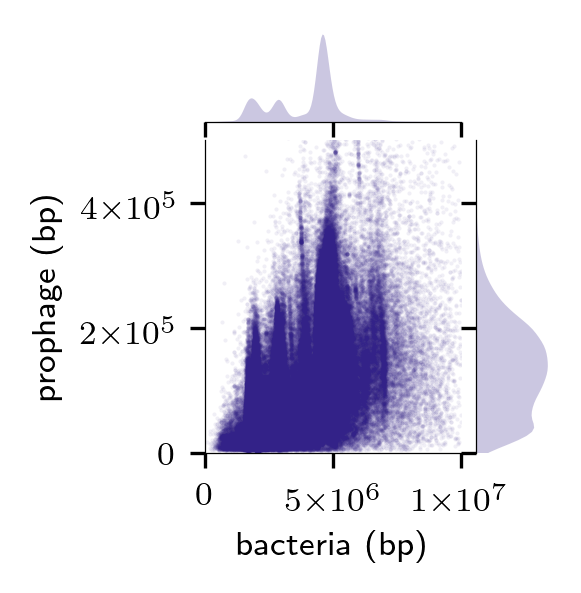

In [44]:
# Create jointgrid subplot 
sizePhage = taxameta.copy()

# Create plot handle and plot data
gt2 = sns.JointGrid(x='normalise_by_prok_length', y='bp prophage', 
                   data=sizePhage[(sizePhage['Kept'] >= minPhages) & 
                                  (sizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (sizePhage['bp prophage'] < 5E6)],
                  xlim=(0,1e7),ylim=(0,5E5), marginal_ticks=False,ratio=3, height=2) # counts normed by genome length

gt2.plot_joint(
    sns.scatterplot, s=1, alpha=0.07, linewidth=0, color=colourDict.get('indigo'),rasterized=True
)
gt2.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=2,color=colourDict.get('indigo'))

# Format axes
gt2.ax_joint.set_xlabel('bacteria (bp)')
gt2.ax_joint.set_ylabel('prophage (bp)')
gt2.ax_joint.set_xticks([0,5E6,1E7])
gt2.ax_joint.yaxis.set_major_formatter(MathTextSciFormatter("%1.0e")), gt2.ax_joint.xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
plt.setp(gt2.ax_marg_y.get_xaxis().get_offset_text(), visible=False)
plt.setp(gt2.ax_marg_x.get_yaxis().get_offset_text(), visible=False)

# Test plot
plt.show()

In [36]:
mpl.rcParams.update(mpl.rcParamsDefault)

Create the same figure from the ~46k GTDB taxdereplicated genomes

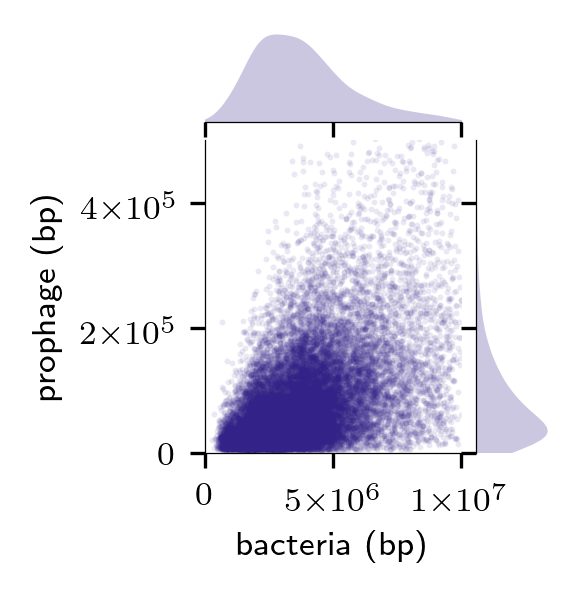

In [45]:
sizePhage = taxameta.copy()
# Subset the data
sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]

# Create plot handle and plot data
gt = sns.JointGrid(x='normalise_by_prok_length', y='bp prophage', 
                   data=sizePhage[(sizePhage['Kept'] >= minPhages) & 
                                  (sizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (sizePhage['bp prophage'] < 5E6)],
                  xlim=(0,1e7),ylim=(0,5E5), marginal_ticks=False,ratio=3, height=2) # counts normed by genome length

gt.plot_joint(
    sns.scatterplot, s=2, alpha=0.1, linewidth=0, color=colourDict.get('indigo'))#,rasterized=True)
gt.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=2,color=colourDict.get('indigo'))

# Format axes
gt.ax_joint.set_xlabel('bacteria (bp)')
gt.ax_joint.set_ylabel('prophage (bp)')
gt.ax_joint.set_xticks([0,5E6,1E7])
gt.ax_joint.yaxis.set_major_formatter(MathTextSciFormatter("%1.0e")), gt.ax_joint.xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
plt.setp(gt.ax_marg_y.get_xaxis().get_offset_text(), visible=False)
plt.setp(gt.ax_marg_x.get_yaxis().get_offset_text(), visible=False)

# Test plot
plt.show()

Do some small calculations needed for Fig 1

In [46]:
# Create some bins to do the size counts for Fig 1b
sizePhage = taxameta.copy()
minval=0
bins = list(np.arange(minval,1.2E7,1.4E6))
sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)

# choose phylogenetic level for Fig 1b, do counts based on mean sizes for that order/class etc
level = 'class'
genomeSize = taxameta.groupby(level).mean()["normalise_by_prok_length"].values
numberGenomes = taxameta.groupby(level).size().values

#### Plot Figure 1

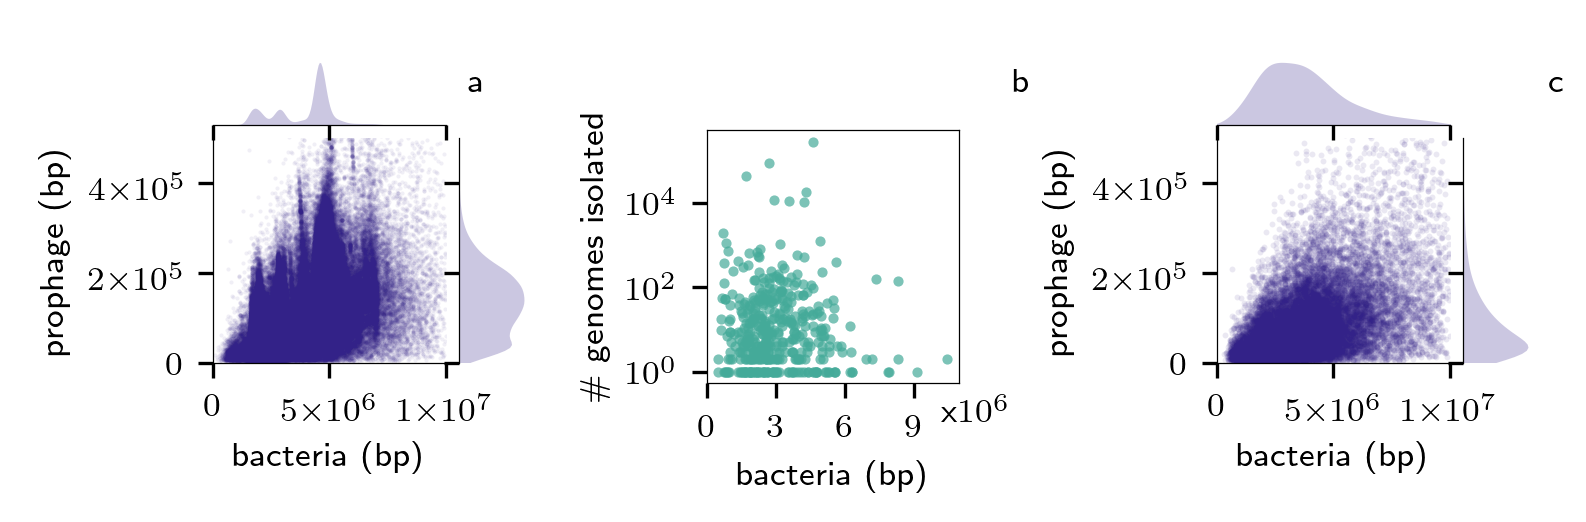

In [47]:
fig = plt.figure(figsize=(fig_width,0.5*fig_height))

outer_gs = gridspec.GridSpec(nrows=1, ncols=1, figure=fig,  wspace=0.4,  hspace=0.5)
gs0 = gridspec.GridSpecFromSubplotSpec(nrows=8, ncols=22, subplot_spec=outer_gs[0], wspace=50, hspace=0)

SeabornFig2Grid(gt2, fig, gs0[0:6,0:6])
SeabornFig2Grid(gt, fig, gs0[0:6,16:22])

f3_ax4 = fig.add_subplot(gs0[2:7,8:13])
sns.scatterplot(x=genomeSize,y=numberGenomes,s=6,alpha=0.7, linewidth=0, ax=f3_ax4,
                   color=colourDict.get('teal'))
f3_ax4.xaxis.offsetText.set_visible(False)
f3_ax4.text(0.93,  -0.15, 'x$10^6$', transform=f3_ax4.transAxes)
f3_ax4.set(yscale='log',yticks=[1,100,10000],xticks=[0,3E6,6E6,9E6],ylabel='\# genomes isolated',
           xlabel='bacteria (bp)')

f3_ax4.annotate('a',(0.275,0.82),xycoords='figure fraction',weight='bold')
f3_ax4.annotate('b',(0.595,0.82),xycoords='figure fraction',weight='bold')
f3_ax4.annotate('c',(0.91,0.82),xycoords='figure fraction',fontweight='bold')

plt.show()

# fig.savefig('./figures/panel1_NEW.pdf', bbox_inches='tight')

#### Get locations of KDE peaks in Fig 1c

In [48]:
df = sizePhage[(sizePhage['Kept'] >= 0)&
                           (sizePhage['normalise_by_prok_length']  < 1E8)&
                           (sizePhage['bp prophage'] < 10E6)  &
                           (sizePhage['assembly_accession'].isin(newickList))]

print('There are',df.shape[0],'genomes in Fig 1c')

There are 36190 genomes in Fig 1c


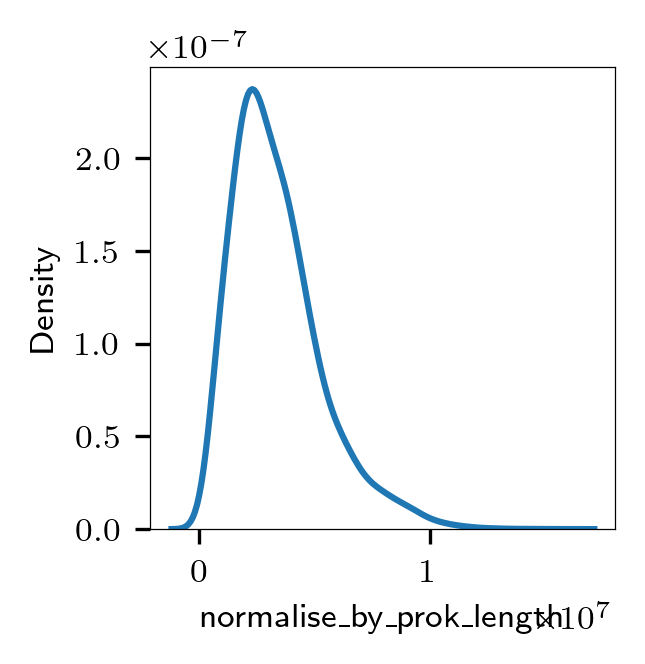

The peak for the bacterial dna total (bp) is at 2.29e+06


In [49]:
fig,ax1=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(df['normalise_by_prok_length'],bw_adjust=2,ax=ax1)
plt.show()
x1 = ax1.lines[0].get_xdata() # Get the x data of the distribution
y1 = ax1.lines[0].get_ydata() # Get the y data of the distribution
maxid1 = np.argmax(y1) 
print('The peak for the bacterial dna total (bp) is at','{:.2e}'.format(x1[maxid1]))

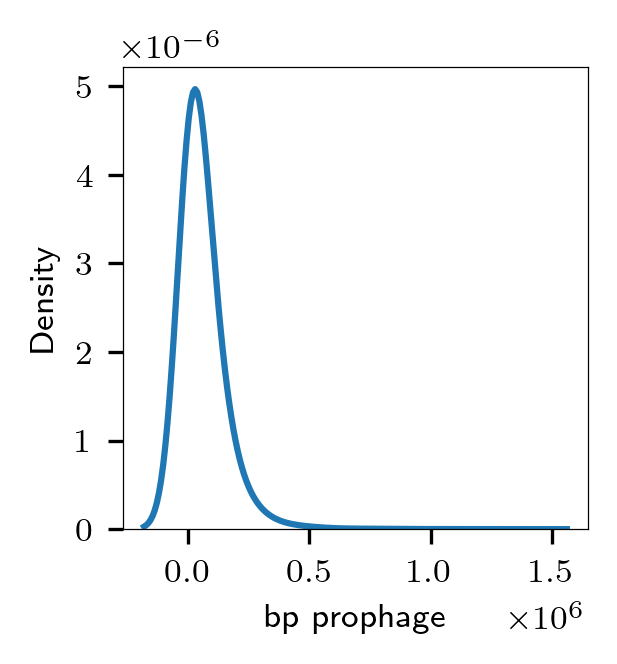

The peak for the genome's content (bp counts) of prophage is 3.06e+04


In [50]:
fig,ax2=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(df['bp prophage'],bw_adjust=6,ax=ax2)
plt.show()
x2 = ax2.lines[0].get_xdata() # Get the x data of the distribution
y2 = ax2.lines[0].get_ydata() # Get the y data of the distribution
maxid2 = np.argmax(y2) 
print('The peak for the genome\'s content (bp counts) of prophage is','{:.2e}'.format(x2[maxid2]))

## Fig 2: Phage size distributions

### Import phage size data

In [51]:
phageLengthDf = allphagedf.copy()

# tmp = phageLengthDf[phageLengthDf['notes'] == 'Kept']
phageLengthDf.rename(columns={'length':'bp'}, inplace=True)

phylumCounts = taxameta.groupby('phylum').count().reset_index()
phyCountDict = dict(zip(phylumCounts['phylum'],phylumCounts['assembly_accession']))

#### Get some size statistics

In [52]:
contigListTh = list(taxameta['assembly_accession'])

prophageSizePlot = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(contigListTh)]

print('Number of prophages in dataset',prophageSizePlot.shape[0],', median size is',prophageSizePlot['bp'].median())
print('Number >20kb is',prophageSizePlot[prophageSizePlot['bp'] >= 20000].shape)

prophageSizePlotGTDB = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(newickList)]

print('Median size in gtdb set is',prophageSizePlotGTDB['bp'].median())

Number of prophages in dataset 2310680 , median size is 22844.0
Number >20kb is (1331473, 7)
Median size in gtdb set is 21201.0


#### Look at the multimodality of individual species' phage size distributions 
Change nspecies to see the top n most abundant species in the database.

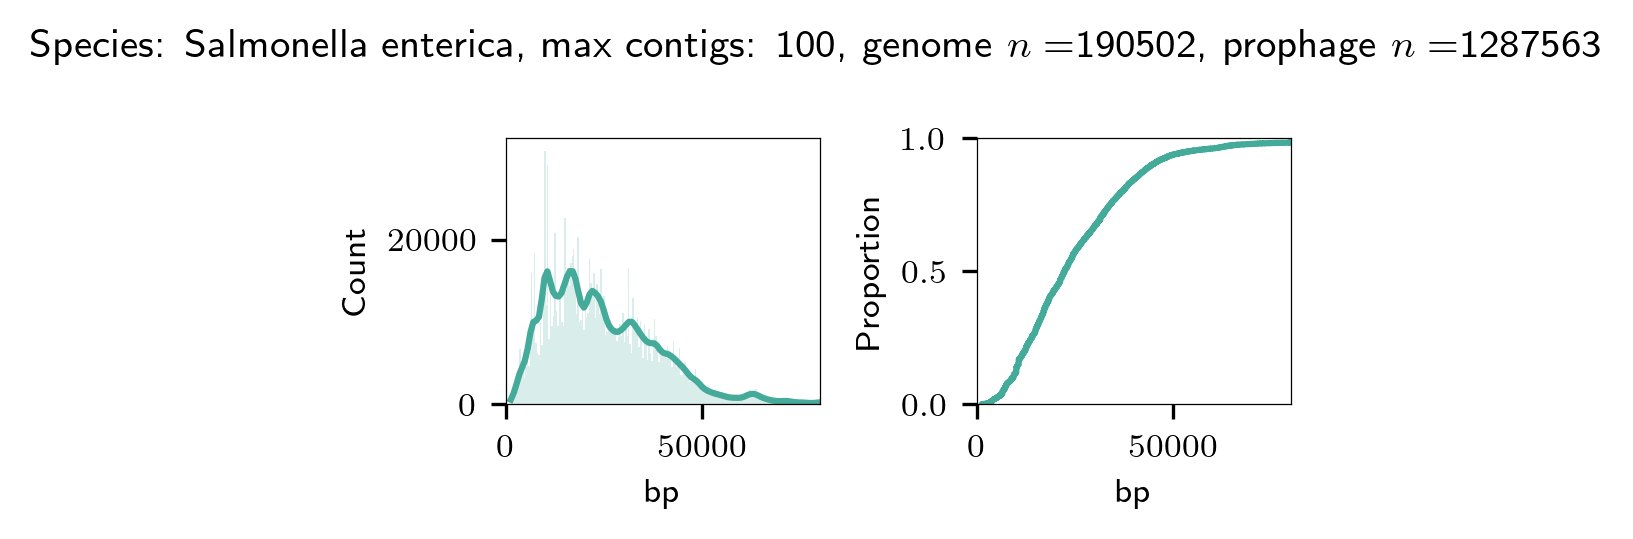

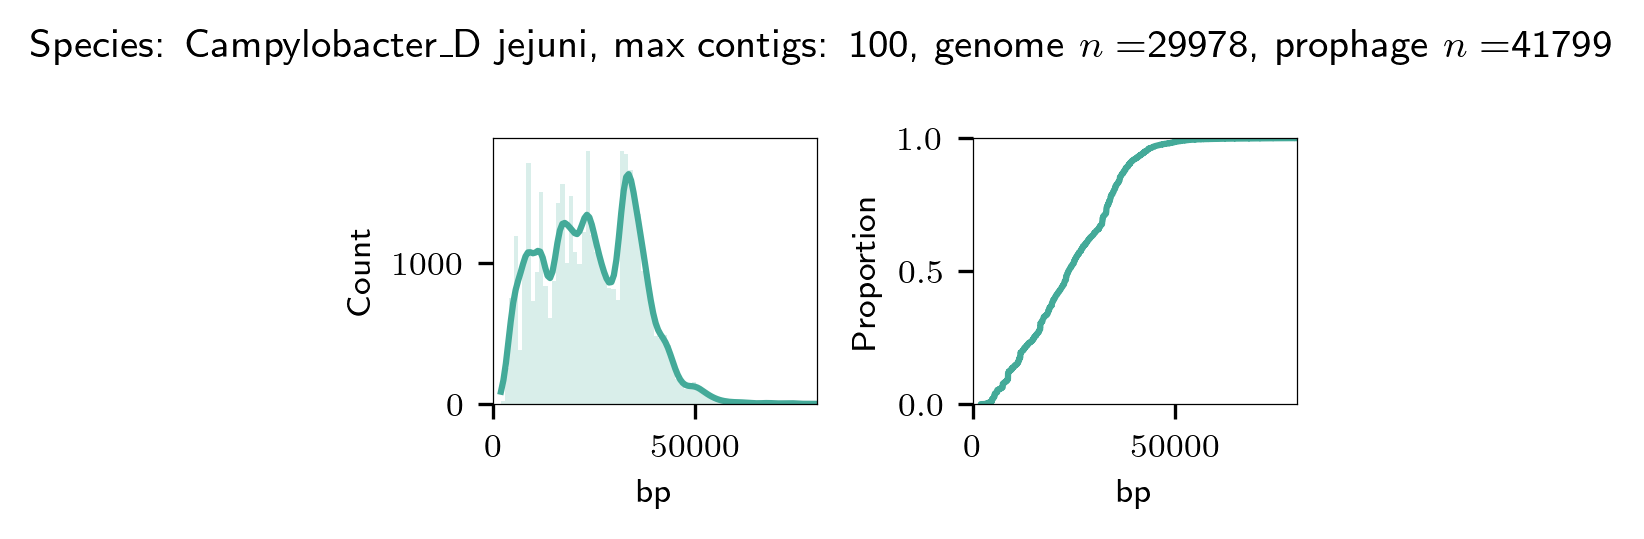

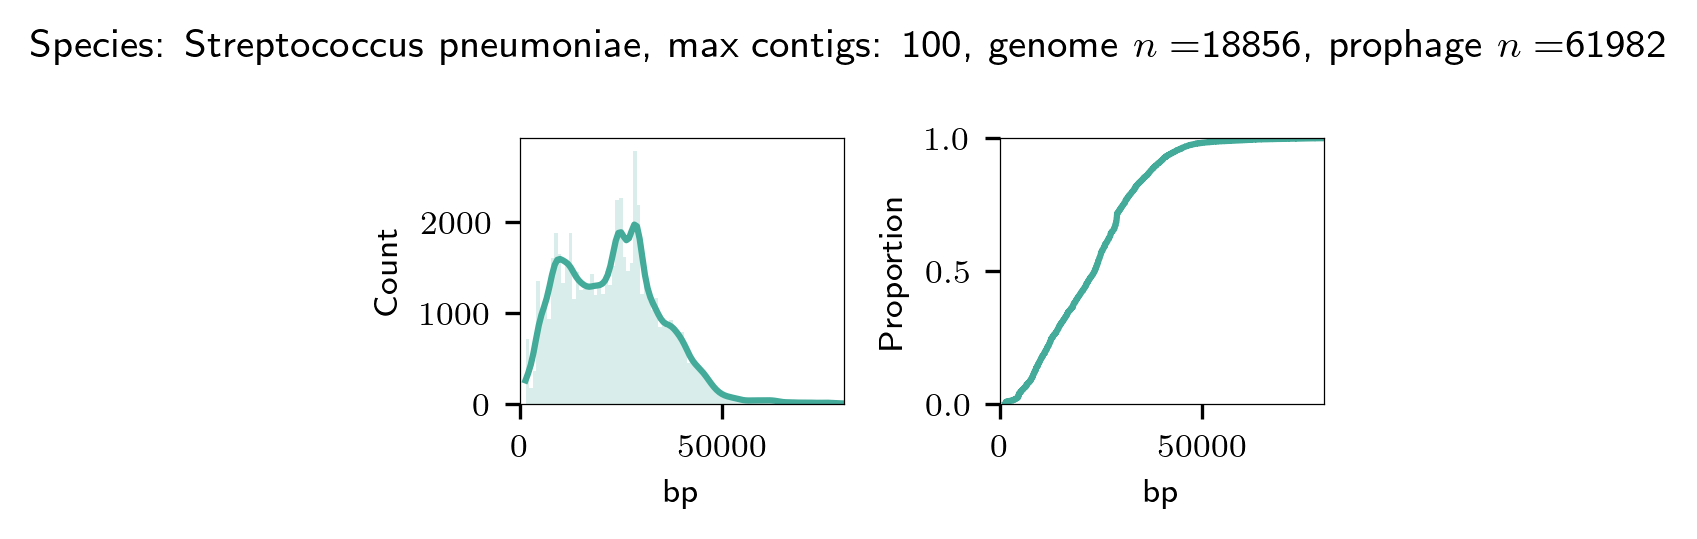

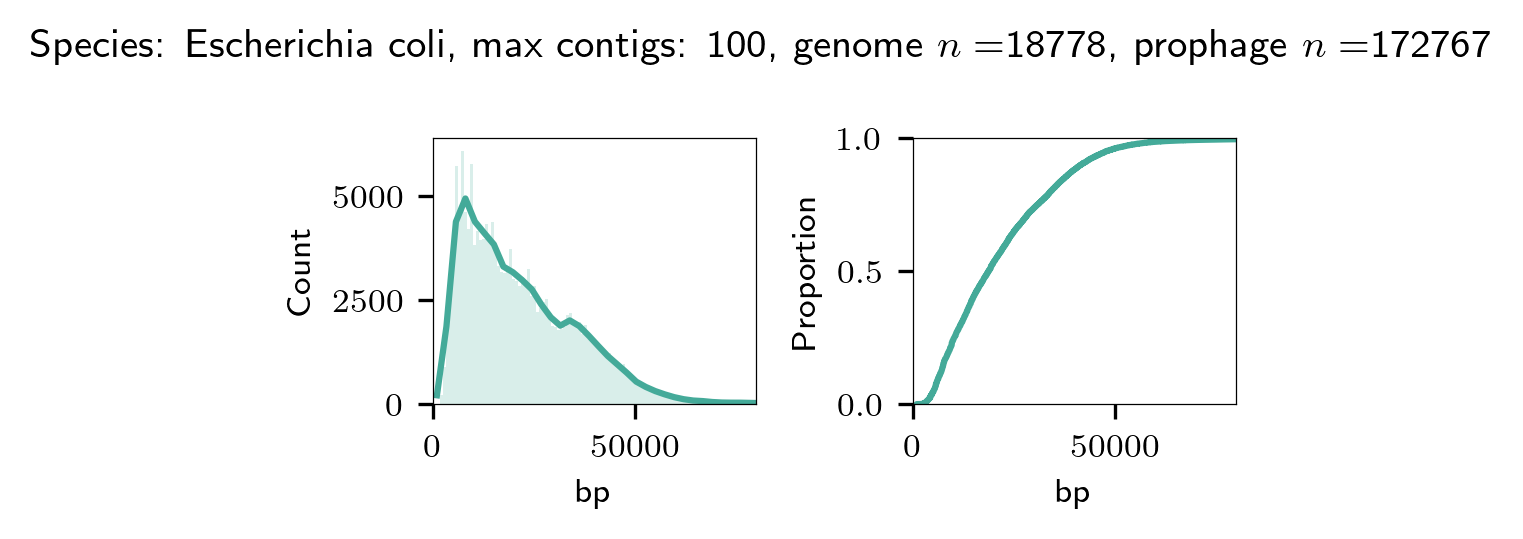

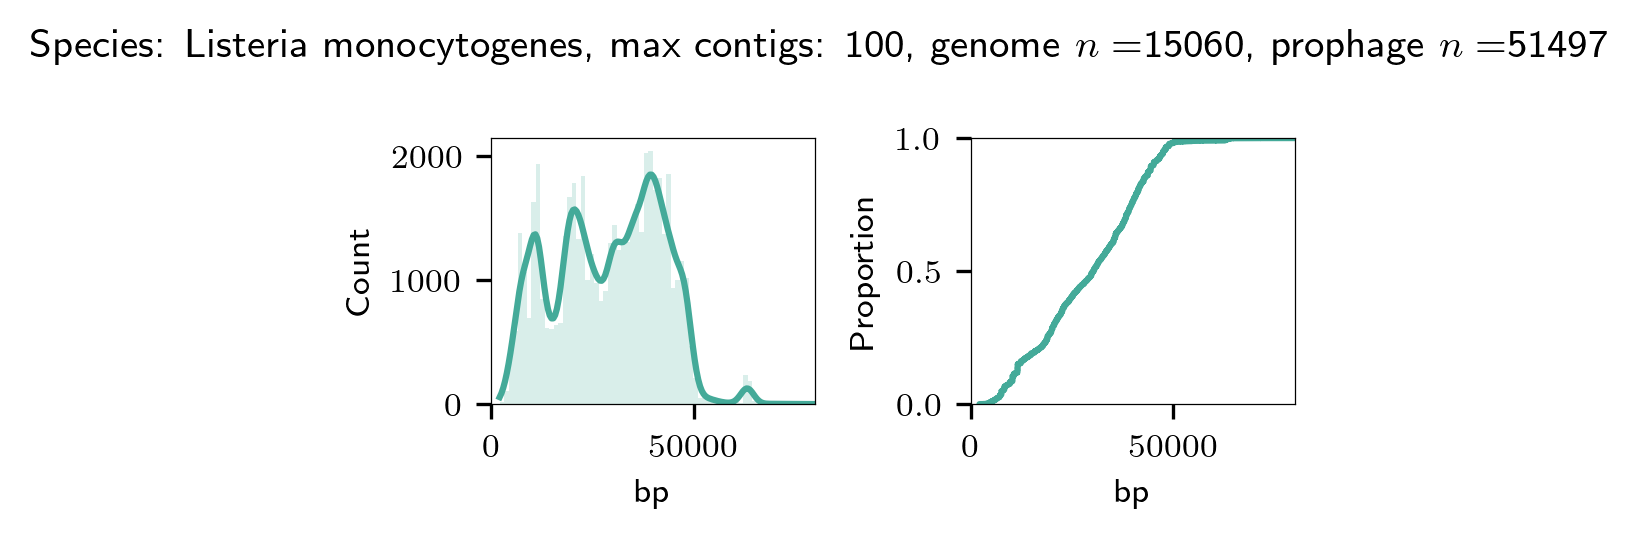

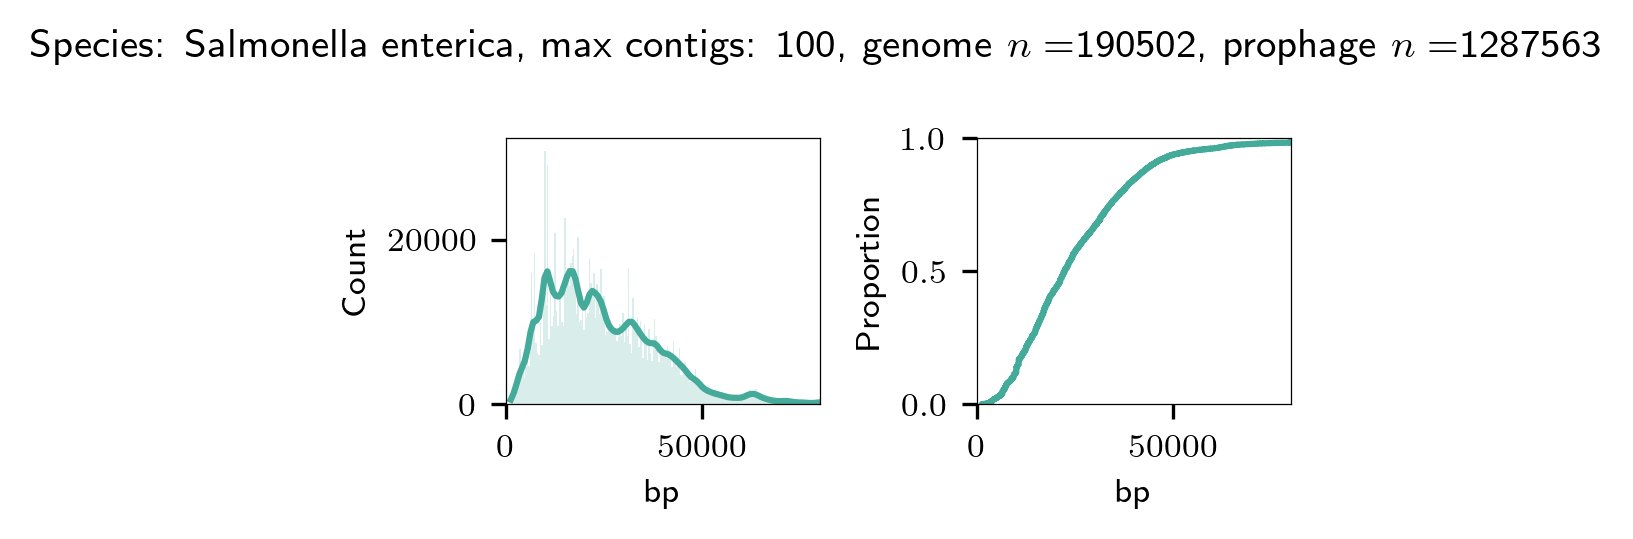

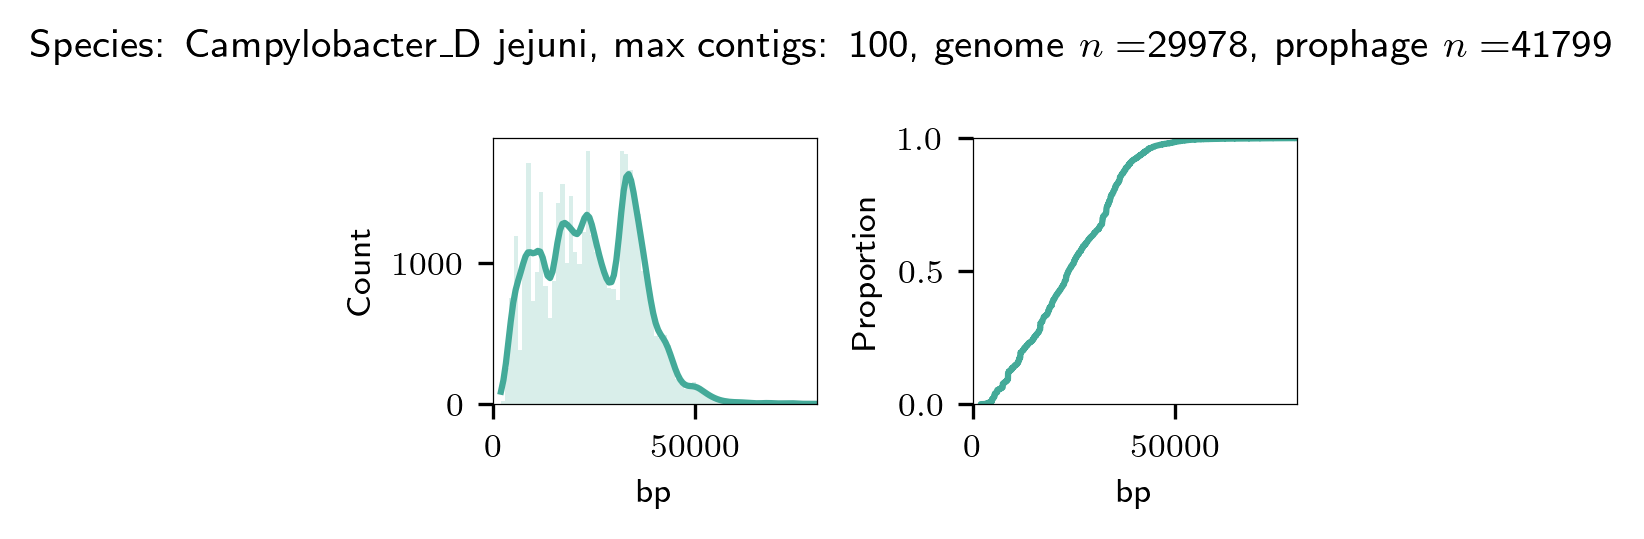

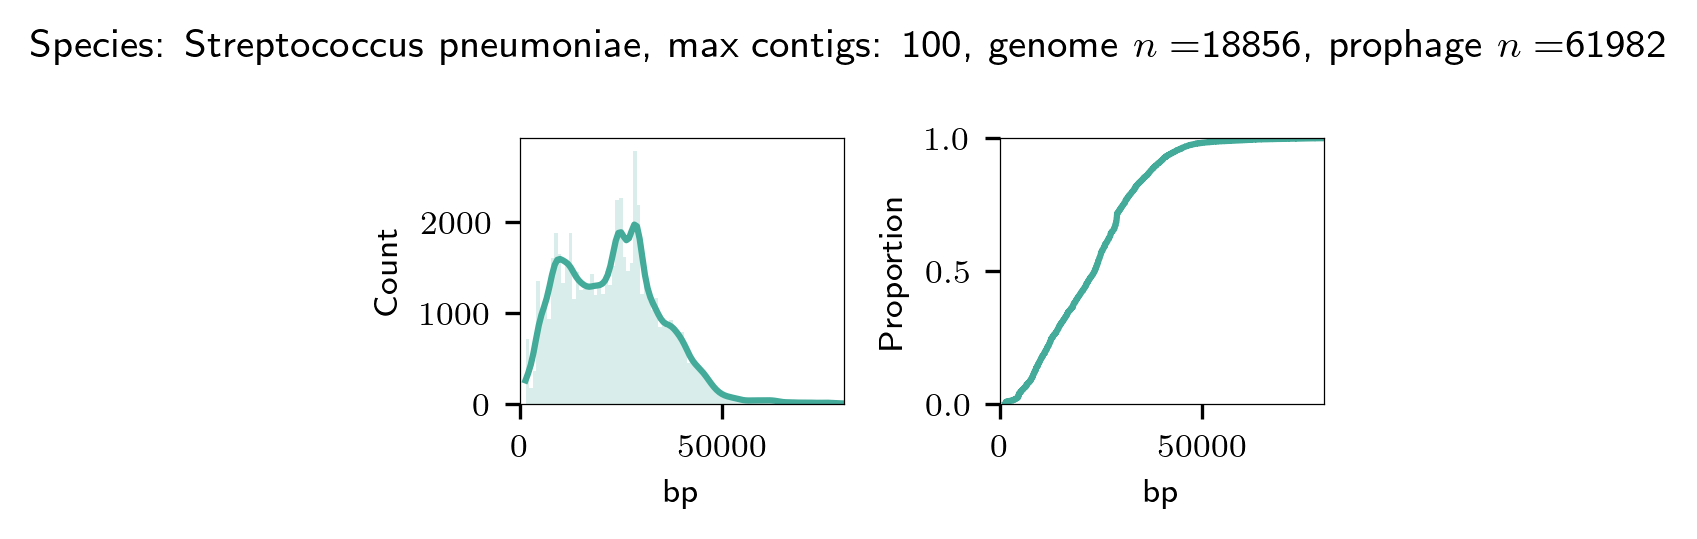

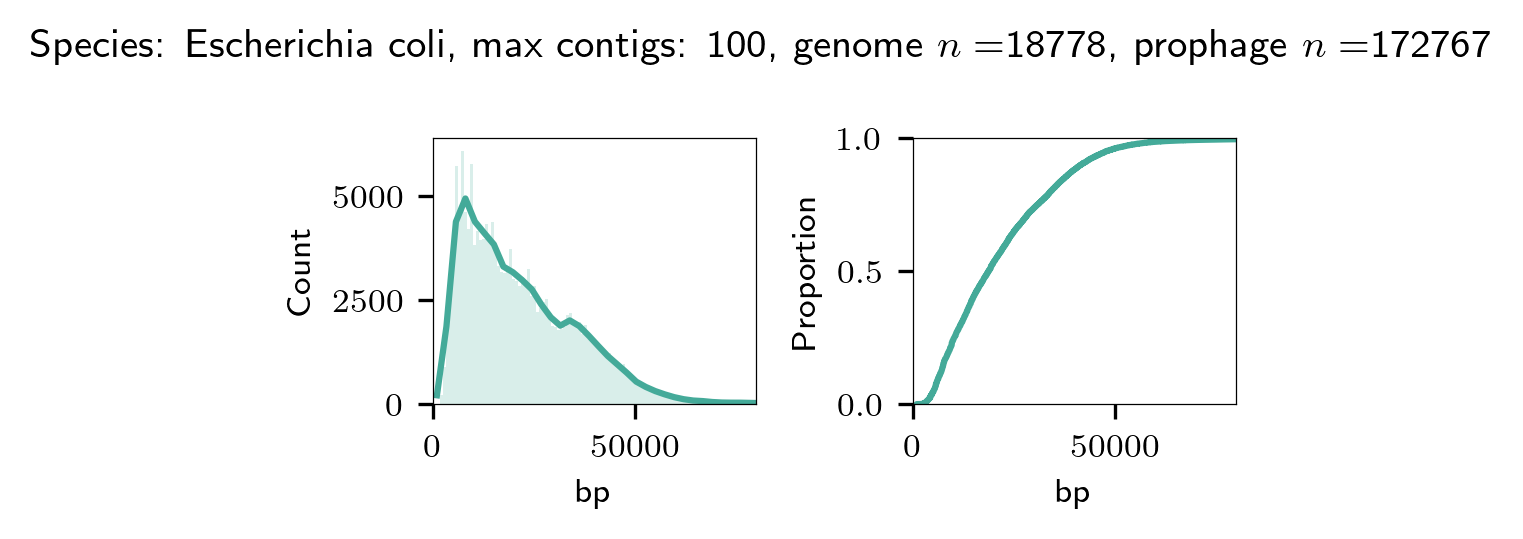

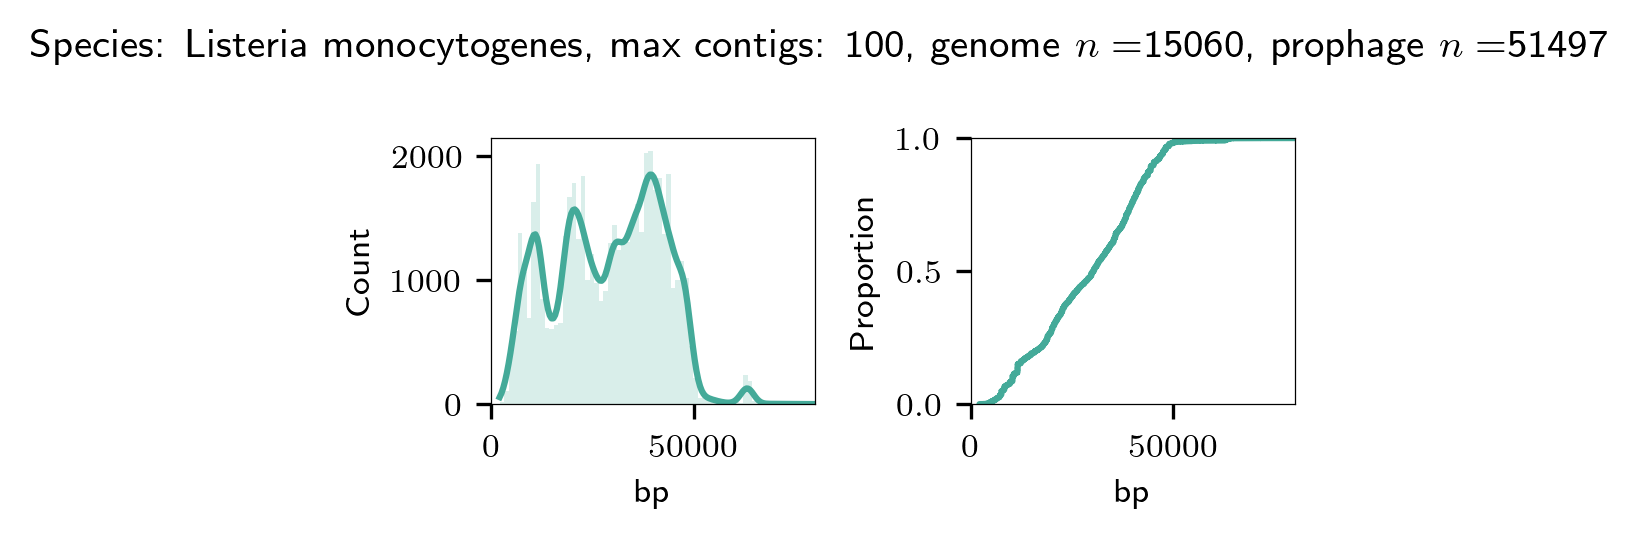

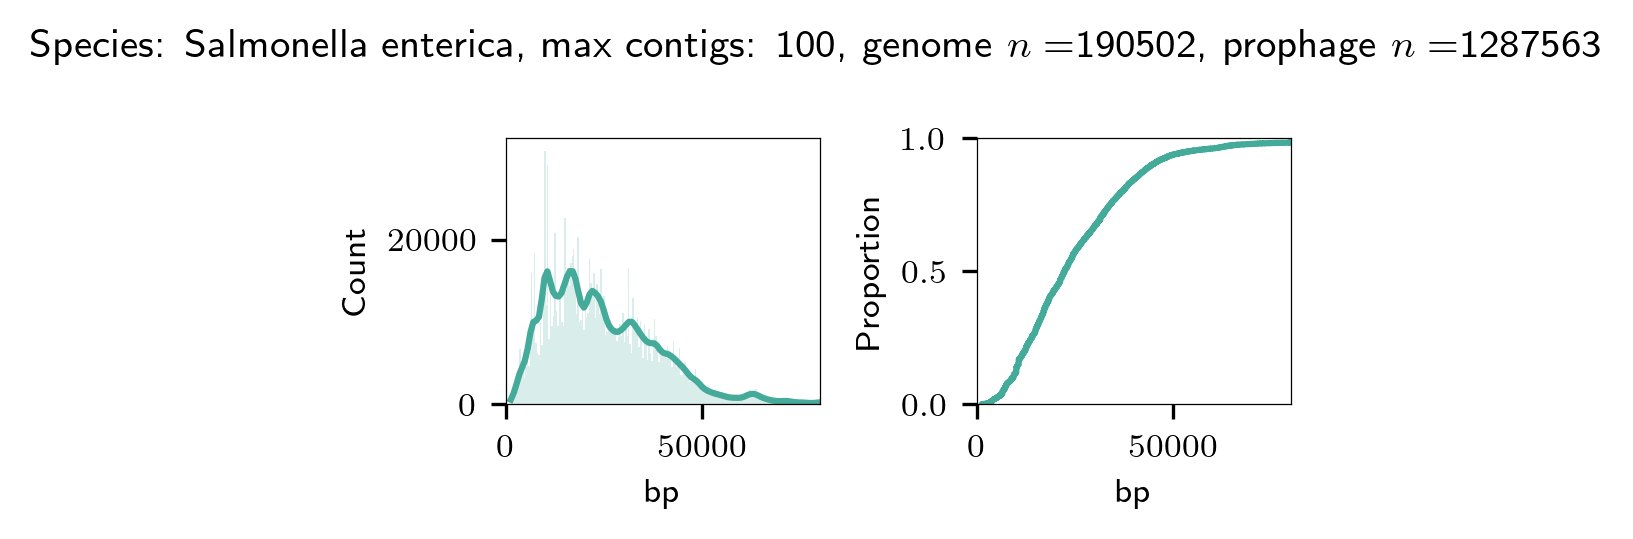

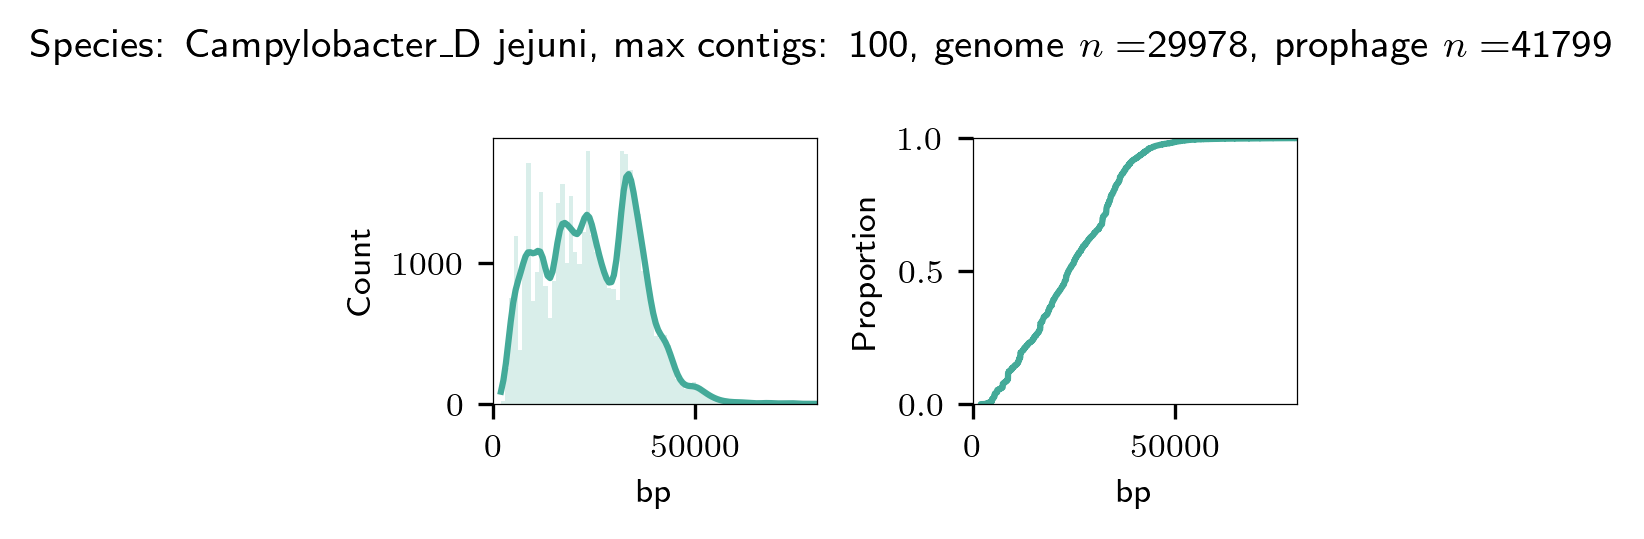

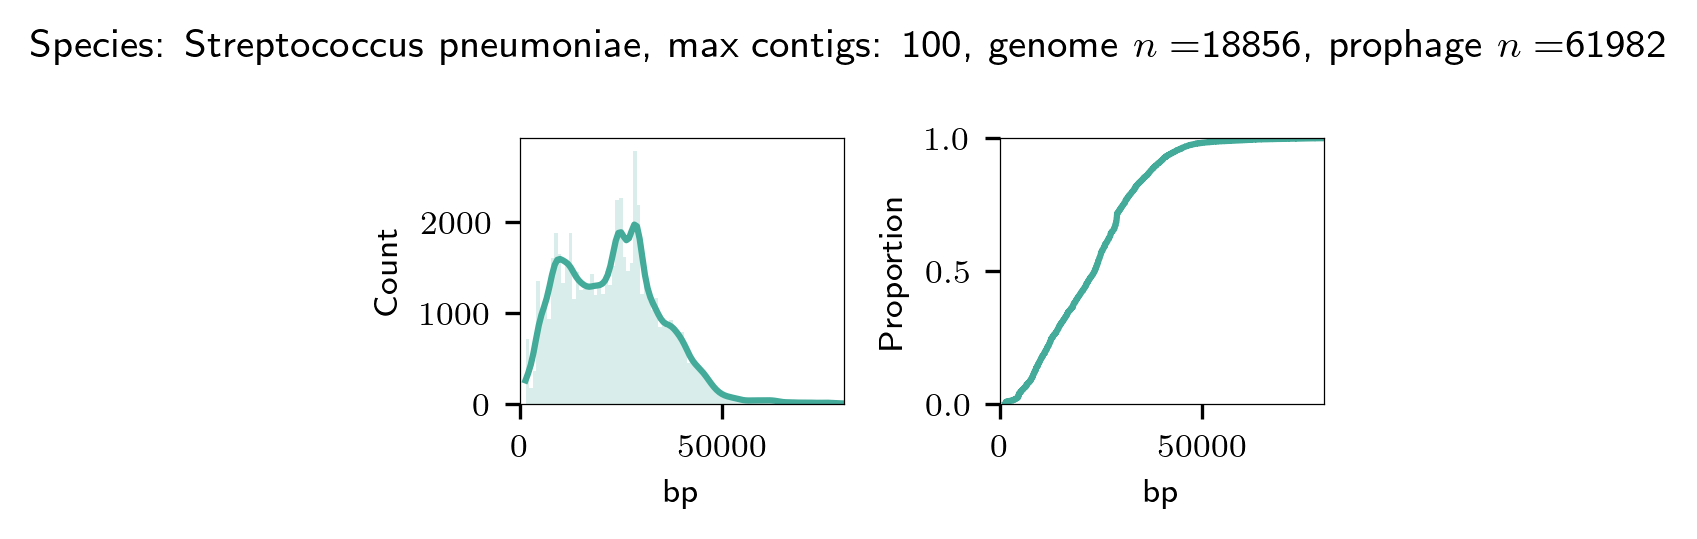

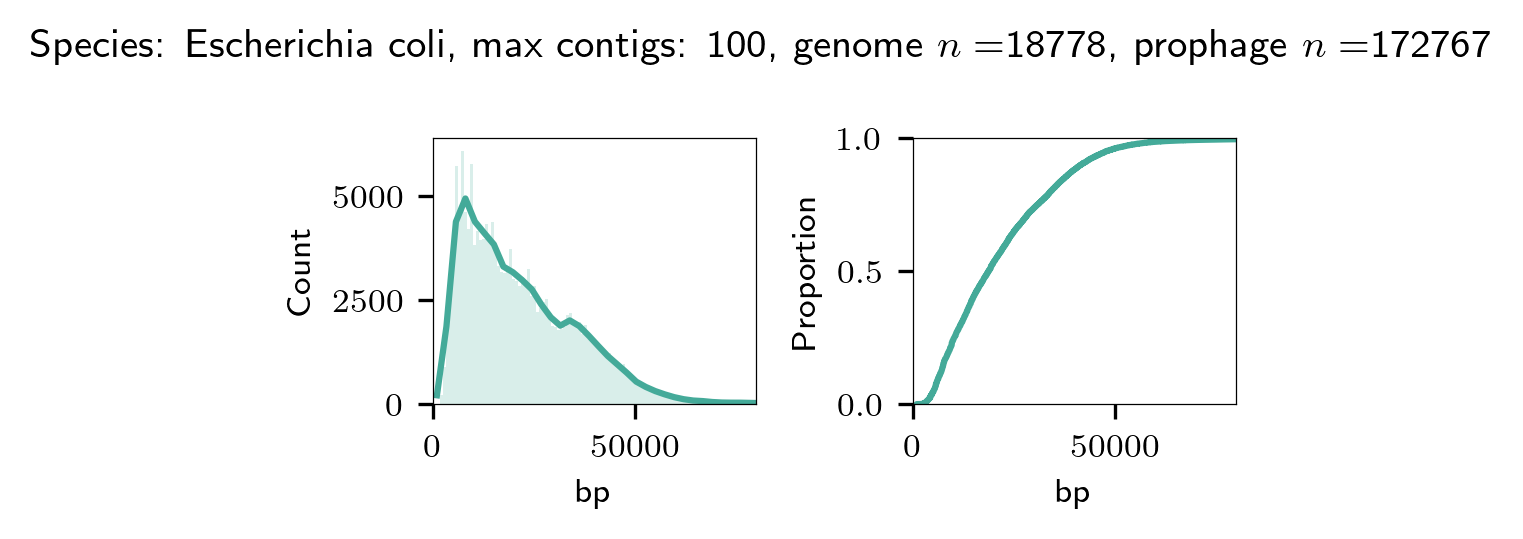

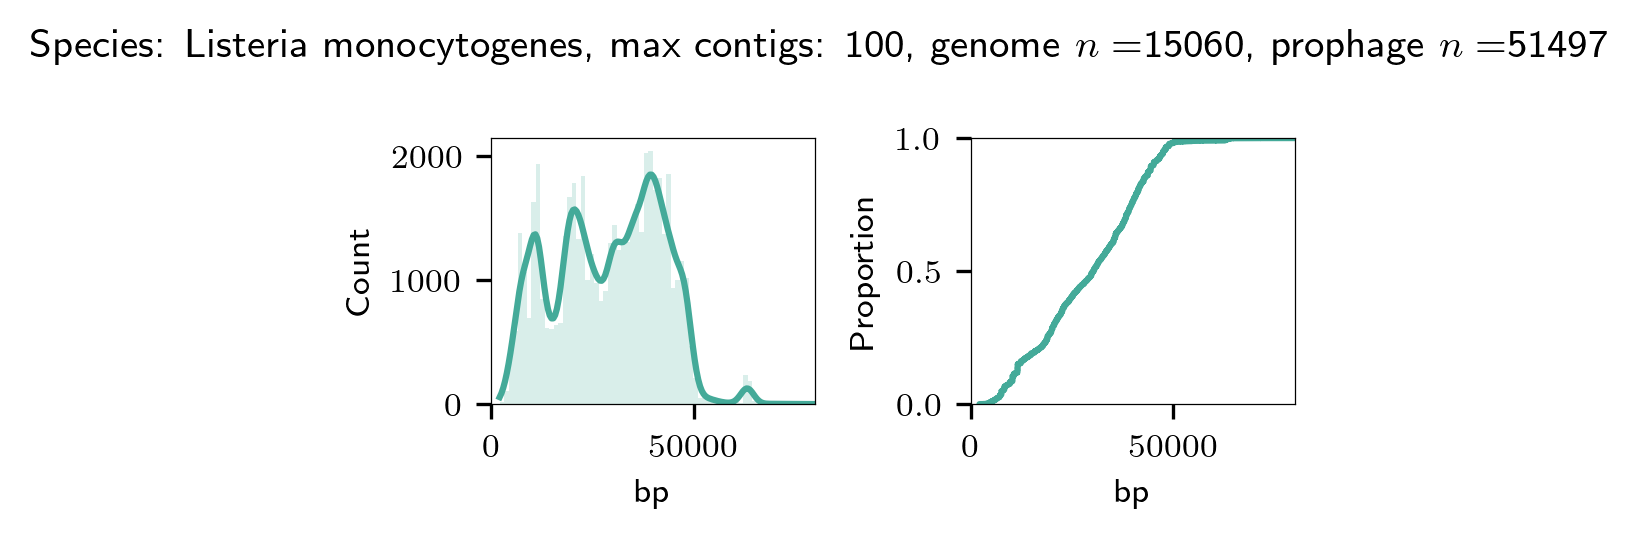

In [61]:
nspecies = 5

topSpecies = list(taxameta['species'].value_counts().head(nspecies).index)
for i in topSpecies:
    speciesName = i #'Staphylococcus aureus' # 'Salmonella enterica' # 'Escherichia coli'  # 'Mycobacterium tuberculosis' #  
    maxcont = maxContig

    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']

    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
        list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))]
    # prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(list(phagemeta['assembly_accession']))]
    nval = prophageSizePlot2.shape[0]
    ngenomes = len(list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))

    fig,ax = plt.subplots(1,2,figsize=(0.6*fig_width,0.5*fig_height))

    sns.histplot(x='bp', data=prophageSizePlot2, kde=True,ax=ax[0], 
                lw=0,alpha=0.2,color=colourDict.get('teal'))
    sns.ecdfplot(x='bp', data=prophageSizePlot2, ax=ax[1],color=colourDict.get('teal'))

    ax[0].set(xlim=[0,8E4])
    ax[1].set(xlim=[0,8E4])

    fig.suptitle('Species: '+speciesName+', max contigs: ' + str(maxContig) + r', genome $n=$'
                 + str(ngenomes)+ r', prophage $n=$' + str(nval))

    fig.tight_layout()
    plt.show()

#     fig.savefig('./figures/phagesizedist/Sp_'+speciesName+'_Cont_' + str(maxcont) + '_GenNum_'
#              + str(ngenomes)+ '_PhNum_' + str(nval), dpi=200)

## Generate Fig 2 panel

#### Generate dataframe for Fig 2b

In [62]:
# 
tmp = taxameta.sample(frac=1).reset_index(drop=True).drop_duplicates(subset='species',keep='first')
tmp = tmp.merge(balancedTax,on='species',how='left')
newickList = list(tmp['assembly_accession_x'])
contigListTh = list(taxameta['assembly_accession'])
prophageSizePlot = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(contigListTh)]
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(newickList)]

#### Generate dataframe for Fig 2a

In [63]:
minval = 0
bins = list(np.arange(minval,1.2E7,1.4E6))  # 1.2
sizePhage = phagemeta.copy()
sizePhage = sizePhage[sizePhage['normalise_by_prok_length'] > 5E4]
sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]
sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)
level = 'class'
# genomeSize = taxameta.groupby(level).mean()["normalise_by_prok_length"].values
# numberGenomes = taxameta.groupby(level).size().values
balancedSizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]
balancedSizePhage = balancedSizePhage[balancedSizePhage['Kept'] > 0]

#### Generate dataframe for Fig 2c-2d

In [64]:
topSpecies = list(taxameta['species'].value_counts().head(5).index)
prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[0]]['assembly_accession']))]
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]

### Plot

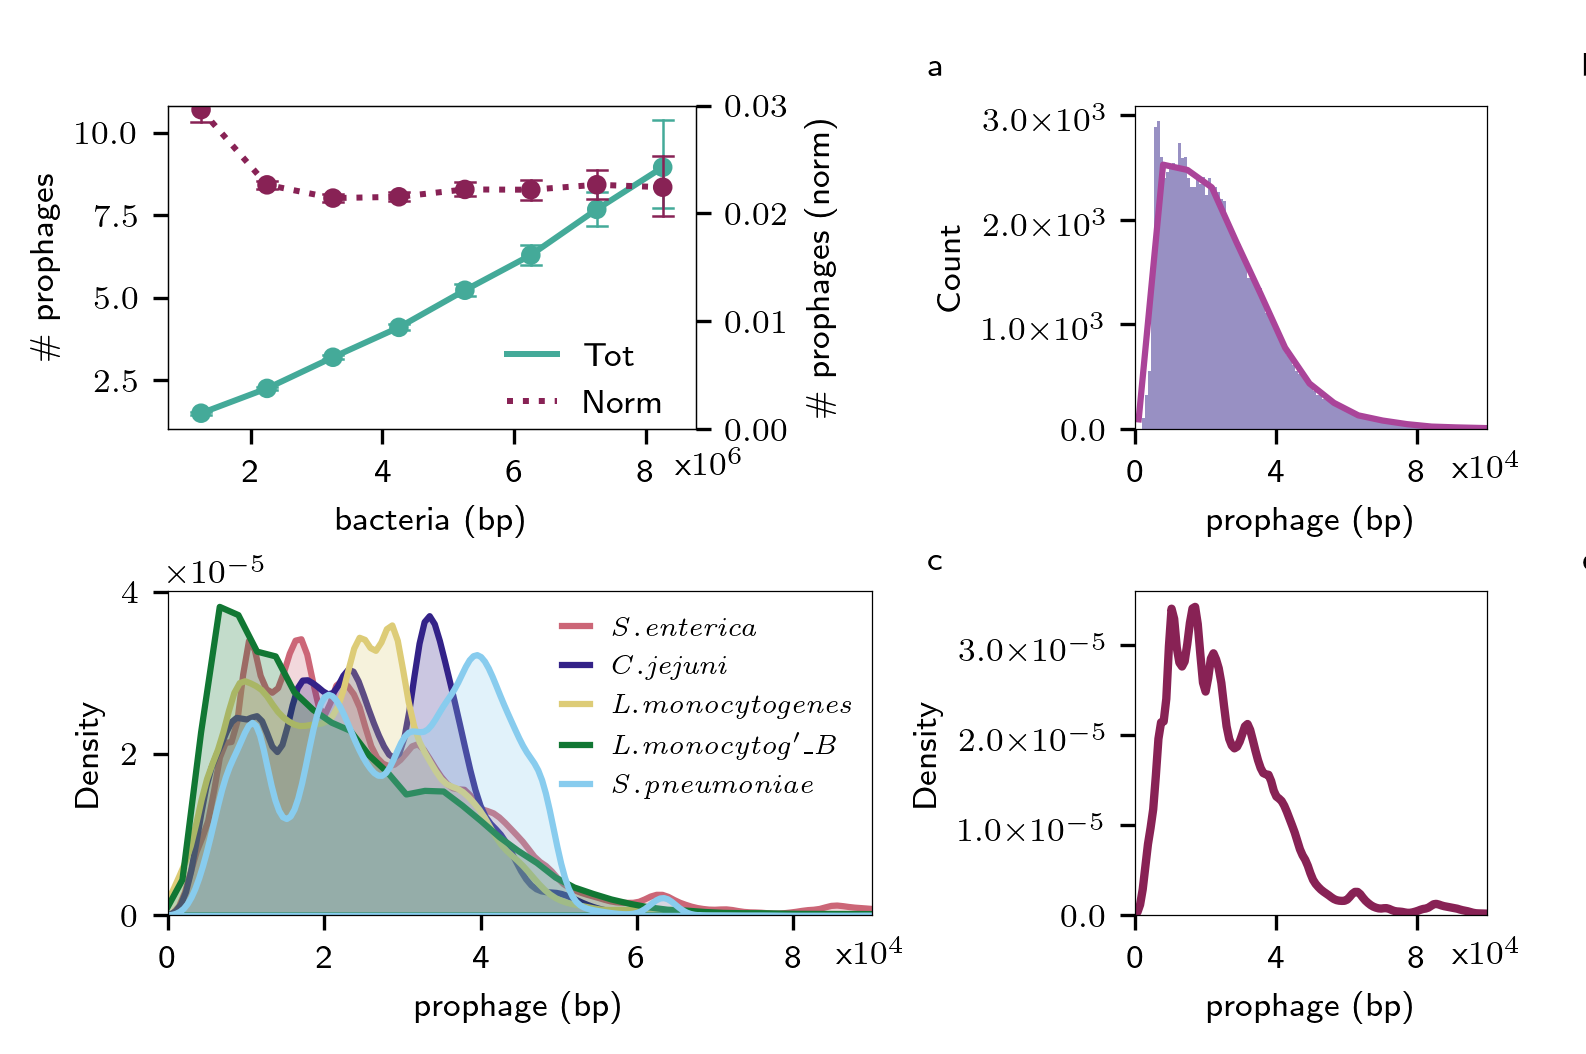

In [65]:
fig = plt.figure(figsize=(fig_width,fig_height))

outer_gs = gridspec.GridSpec(nrows=2, ncols=1, figure=fig,  wspace=0.4,  hspace=0.5)
gs0 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=15, subplot_spec=outer_gs[0], wspace=0, hspace=0)
gs1 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=15, subplot_spec=outer_gs[1], wspace=0, hspace=0)


ax0 = fig.add_subplot(gs0[0:,0:6])
ax1 = fig.add_subplot(gs0[0:,11:15])
ax4 = fig.add_subplot(gs1[0:,0:8])
ax2 = fig.add_subplot(gs1[0:,11:15])

with plt.rc_context({'lines.linewidth': 0.8}):
        s1 = sns.pointplot(x='bin_centres', y='Kept', data=balancedSizePhage,nboot=5000, ax = ax0, 
                  color=colourDict.get('teal'), alpha=0.6, s=8, 
                 capsize=.3, errwidth=0.6) 

ax3 = ax0.twinx()
with plt.rc_context({'lines.linewidth': 0.8}):
    s2 = sns.pointplot(x='bin_centres', y='Kept_normed', data=balancedSizePhage, ax=ax3, n_boot=25000,
                  color=colourDict.get('wine'), alpha=0.6, s=8, linestyles=':',
                 capsize=.3, errwidth=0.6)

ax3.xaxis.offsetText.set_visible(False)
labels = ax0.get_xticklabels()
ax0.set(ylabel='\# prophages',xlabel='bacteria (bp)',xticks =[0.75,2.75,4.75,6.75],xticklabels=[2,4,6,8])
ax0.text(0.96,  -0.14,'x$10^6$', transform=ax0.transAxes)
ax3.set(ylabel='\# prophages (norm)',ylim=[0,0.03])

L = ax0.legend(s1.lines[:1]+s2.lines[:1], ['A','G'],handlelength=1.5,loc='lower right',bbox_to_anchor=(1.0, -0.06),frameon=False)
L.get_texts()[0].set_text('Tot')
L.get_texts()[1].set_text('Norm')



sns.histplot(x='bp', data=prophageSizePlot, ax=ax1, kde=True, linewidth=0,color=colourDict.get('indigo'))
ax1.set(xlim=[1E2,1E5], xlabel='prophage (bp)')
ax1.yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
ax1.set(xlim=[1E2,1E5], xlabel='prophage (bp)',xticks=[0,40000,80000],xticklabels=['0','4','8'],
           ylabel='Count')
ax1.text(0.9,  -0.15, 'x$10^4$', transform=ax1.transAxes)

ax1.lines[0].set_color(colourDict.get('purple'))



sns.kdeplot(x='bp', data=prophageSizePlot2, ax=ax2, linewidth=2,color=colourDict.get('wine'))
ax2.set(xlim=[1E2,1E5], xlabel='prophage (bp)')
ax2.yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
ax2.set(xlim=[1E2,1E5], xlabel='prophage (bp)',xticks=[0,40000,80000],xticklabels=['0','4','8'],
           ylabel='Density')
ax2.text(0.9,  -0.15, 'x$10^4$', transform=ax2.transAxes)

counter=0
colList = list(colourDict.values())
for i in topSpecies:
      
#     colourVal = colList[counter]
    
    speciesName = i #'Staphylococcus aureus' # 'Salmonella enterica' # 'Escherichia coli'  # 'Mycobacterium tuberculosis' #  
    maxcont = maxContig

    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
        list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))]
    # prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(list(phagemeta['assembly_accession']))]
    nval = prophageSizePlot2.shape[0]
    ngenomes = len(list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))
    
    sns.kdeplot(x='bp', data=prophageSizePlot2, ax=ax4, lw=1.5,fill=True, color=colList[counter])#,color=colourDict.get('teal'))
    counter=counter+1

#     fig.suptitle('Species: '+speciesName+', max contigs: ' + str(maxContig) + r', genome $n=$'
#                  + str(ngenomes)+ r', prophage $n=$' + str(nval))
ax4.set(xlim=[0,9E4], xlabel='prophage (bp)',xticks=[0,2E4,4E4,6E4,8E4],xticklabels=['0','2','4','6','8'])
ax4.text(0.95,  -0.15, 'x$10^4$', transform=ax4.transAxes)


custom_lines = [Line2D([0], [0], color=colList[0], lw=1.5),
                Line2D([0], [0], color=colList[1], lw=1.5),
                Line2D([0], [0], color=colList[2], lw=1.5),
                Line2D([0], [0], color=colList[3], lw=1.5),
                Line2D([0], [0], color=colList[4], lw=1.5)]

ax4.legend(custom_lines, ["$\it{S. enterica}$","$\it{C. jejuni}$","$\it{L. monocytogenes}$","$\it{L. monocytog'\_B}$","$\it{S. pneumoniae}$"], 
           handlelength=1,frameon=False, loc='upper right',bbox_to_anchor=(1.01, 1), fontsize='small')
# ax4.legend()

plt.annotate('a',(0.545,0.93),xycoords='figure fraction',weight='bold')
plt.annotate('b',(0.93,0.93),xycoords='figure fraction',weight='bold')
plt.annotate('c',(0.545,0.46),xycoords='figure fraction',fontweight='bold')
plt.annotate('d',(0.93,0.46),xycoords='figure fraction',fontweight='bold')


plt.show()

# fig.savefig('./figures/panel2_NEW.png',dpi=600,bbox_inches='tight')

### Check for multimodality in Fig 2b and Fig 2d

In [48]:
# import R packages
diptest=importr('diptest')
permute=importr('permute')
lattice=importr('lattice')
spatstat=importr('spatstat')
pandas2ri.activate()

# Test balanced taxonomy set
dat = np.array(prophageSizePlot['bp'])
print('p-value for Hartigan\'s dip test, balanced GTDB set is',diptest.dip_test(dat)[1])

# Test for Salmonella 
prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[0]]['assembly_accession']))]
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]

dat = np.array(prophageSizePlot2['bp'].sample(71999))
print('p-value for Hartigan\'s dip test, Salmonella E. is',diptest.dip_test(dat)[1])

p-value for Hartigan's dip test, balanced GTDB set is [0.99269334]
p-value for Hartigan's dip test, Salmonella E. is [0.]


#### Check multimodality for top 5 most abundant species in database

In [50]:
for i in range(0,5):
    maxcont = maxContig
    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[i]]['assembly_accession']))]
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]
    try:
        dat = np.array(prophageSizePlot2['bp'].sample(71999))
    except:
        dat = np.array(prophageSizePlot2['bp'])
        
    print('For',topSpecies[i], 'p-value for Hartigan\'s dip test for prophage size distribution',diptest.dip_test(dat)[1])

For Salmonella enterica p-value for Hartigan's dip test for prophage size distribution [0.]
For Campylobacter_D jejuni p-value for Hartigan's dip test for prophage size distribution [0.]
For Streptococcus pneumoniae p-value for Hartigan's dip test for prophage size distribution [0.]
For Listeria monocytogenes p-value for Hartigan's dip test for prophage size distribution [0.]
For Listeria monocytogenes_B p-value for Hartigan's dip test for prophage size distribution [0.]


## Figure 3

Use the genbank assembly summary to get additional metadata e.g. MAG status, as well as isolation date (proxied as sample date)

In [122]:
assembly_summary = pd.read_csv('../data/assembly_summary.txt.gz', compression='gzip',sep='\t',skiprows=1)
assembly_summary.rename(columns={'# assembly_accession':'assembly_accession'},inplace=True)

/Users/JFisher/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Update dates and MAG status in the Genbank summary file

In [123]:
assembly_summarySub = assembly_summary[['assembly_accession','seq_rel_date','excluded_from_refseq']]
assembly_summarySub.loc[:,'excluded_from_refseq'] = assembly_summarySub.loc[:,'excluded_from_refseq'].astype(str)
assembly_summarySub.loc[:,'MAG status'] = assembly_summarySub['excluded_from_refseq'].apply(lambda x: metagenomeStatus(x))
assembly_summarySub.loc[:,'isolation_date'] = assembly_summarySub.seq_rel_date.apply(dc.convert_date)
assembly_summaryMag = assembly_summarySub[assembly_summarySub['MAG status'] == "Yes"]

# # Create lists of genomes which are MAGs, and the dates they were "isolated" (sampled)
magAccs = list(assembly_summaryMag['assembly_accession'])
magDateDict = dict(zip(assembly_summarySub['assembly_accession'],assembly_summarySub['isolation_date']))

/Users/JFisher/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/JFisher/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/JFisher/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

#### Plot the joint distribution

/Users/JFisher/anaconda3/envs/prophage-distributions/lib/python3.8/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


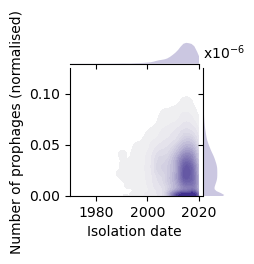

In [282]:
tmpKDE = taxameta[taxameta['isolation_date'].notnull()]

gr = sns.JointGrid(x='isolation_date', y='Kept_normed', data=tmpKDE,xlim=(1970, 2020), ylim=(0, 0.125), height=2) # counts normed by genome length
gr.plot_joint(sns.kdeplot, fill=True, cmap="light:"+colourDict.get('indigo'), n_levels=25,cbar=False)
gr.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=1.4,color=colourDict.get('indigo')) # "#03012d"

gr.ax_joint.set_xlabel('Isolation date')
gr.ax_joint.set_ylabel('Number of prophages (normalised)')

gr.ax_joint.yaxis.offsetText.set_visible(False)
gr.ax_joint.text(x = 1.03, y = 1.07, s = 'x$10^{-6}$', transform=gr.ax_joint.transAxes)#,xy=(0.01,1), xycoords='figure fraction')
plt.setp(gr.ax_marg_y.get_yticklabels(), visible=False)

plt.show()

#### Generate metadata for plot

In [291]:
level = 'phylum'
normtype = 'Kept_normed'
earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[level,'isolation_date']].groupby(level).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
earliestDict = dict(zip(earliestIsoltionDf[level],earliestIsoltionDf['isolation_datemin']))
taxameta['isolation_datemin'] = taxameta[level].map(earliestDict)

earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[level,'isolation_date']].groupby(level).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
earliestDict = dict(zip(earliestIsoltionDf[level],earliestIsoltionDf['isolation_datemin']))
firstIsolated = taxameta.groupby('phylum').mean().reset_index()
firstIsolated = firstIsolated[firstIsolated['isolation_datemin'] > 1850]

procKept = phageLengthDf.groupby(['assembly_accession','notes']).sum().reset_index()
procKept = procKept.pivot(index='assembly_accession', columns='notes', values='bp').reset_index()
procKept = procKept.rename_axis(None, axis="columns")
procKept.fillna(0, inplace=True)

procKept['discard'] = procKept['Dropped. No genes were identified as phage genes'
                              ] + procKept['Dropped. Not enough genes'
                                          ] + procKept['Dropped. Region too small (Not enough genes)']
tmp2 = taxameta[['assembly_accession',level,'bp prophage']].merge(procKept,on='assembly_accession')
keptExplore = pd.DataFrame(tmp2.groupby(level)["discard"].mean()).reset_index()
keptExplore['bp prophage'] = tmp2.groupby(level)["bp prophage"].mean().values
keptExplore['isolation_datemin'] = keptExplore[level].map(earliestDict)
keptExplore['bp found'] = keptExplore['discard'].values + keptExplore['bp prophage'].values
keptExplore['prop kept'] = keptExplore['bp prophage'].values / (keptExplore['bp prophage'].values 
                                                                + keptExplore['discard'].values) # +1

 
bins2 = np.arange(1810,2024,1)
yearTaxa2 = taxameta.copy()
yearTaxa2 = yearTaxa2[~yearTaxa2['isolation_date'].isnull()]
yearTaxa2 = yearTaxa2[yearTaxa2['isolation_date'] < 2019]
yearTaxa2['bin'] = pd.cut(taxameta['isolation_date'], bins2)
yearTaxa2["bin_centres"] = yearTaxa2["bin"].apply(lambda x: x.mid).astype(np.float64)
# yearTaxa_dropNaN = yearTaxa[~yearTaxa['isolation_date'].isna()]
binsets3 = list(yearTaxa2['bin_centres'].unique())
yearList3 = []

for binVal in binsets3:
    num = len(yearTaxa2[yearTaxa2['bin_centres'] == binVal])
    subDf = yearTaxa2[yearTaxa2['bin_centres'] == binVal]
    numzeros = len(subDf[subDf['Kept'] == 0])
    yearList3 += [numzeros]

In [292]:
procKept

,assembly_accession,Dropped. No genes were identified as phage genes,Dropped. Not enough genes,Dropped. Region too small (Not enough genes),Kept,discard
0,GCA_000003135.1,7209.0,12542.0,0.0,48918.0,19751.0
1,GCA_000003645.1,198733.0,35383.0,0.0,40298.0,234116.0
2,GCA_000003925.1,270483.0,15410.0,0.0,268087.0,285893.0
3,GCA_000003955.1,238858.0,35727.0,0.0,166292.0,274585.0
4,GCA_000005825.2,236529.0,67078.0,0.0,93419.0,303607.0
...,...,...,...,...,...,...
945546,GCA_940677155.1,0.0,0.0,26737.0,70598.0,26737.0
945547,GCA_940677165.1,0.0,0.0,34179.0,131145.0,34179.0
945548,GCA_940677175.1,20156.0,0.0,24643.0,61083.0,44799.0
945549,GCA_940677185.1,6040.0,0.0,31868.0,91868.0,37908.0


#### Plot fig 3

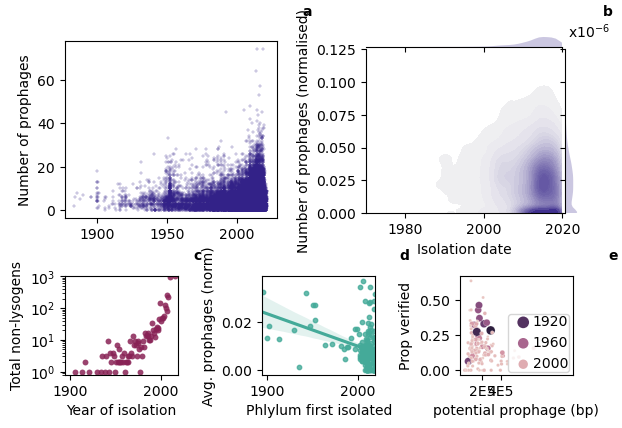

In [301]:
fig = plt.figure(figsize=(fig_width*1.1,1.2*fig_height))
# plt.figure()

gs = gridspec.GridSpec(5, 6)

f3_ax1 = fig.add_subplot(gs[0:3, 0:3])
sns.scatterplot(x='isolation_date', y='Kept', ax = f3_ax1, 
                data=taxameta[(taxameta['isolation_date'].notnull()) & (taxameta['isolation_date'] > 1850)], 
                marker='+', color=colourDict.get('indigo'), alpha=0.6, s=8)

f3_ax2 = SeabornFig2Grid(gr, fig, gs[0:3, 3:6])

f3_ax3 = fig.add_subplot(gs[3:5, 0:2])
sns.scatterplot(x=binsets3,y=yearList3, linewidth=0, ax=f3_ax3,s=18,alpha=0.85, 
                color=colourDict.get('wine'))
f3_ax3.set(xlabel='Year of isolation', ylabel='Total non-lysogens', yscale='log',
          xlim=[1894,2019],ylim=[0.8,1E3])

f3_ax4 = fig.add_subplot(gs[3:5, 4:6])
sns.scatterplot(x='bp found',y='prop kept', data=keptExplore[keptExplore['isolation_datemin']>=1900],
               hue='isolation_datemin', size='isolation_datemin',sizes=(40,3),
               palette=sns.cubehelix_palette(as_cmap=True).reversed(), ax=f3_ax4)
f3_ax4.set(xticks=[2E5,4E5],xticklabels=['2E5','4E5'],xlabel='potential prophage (bp)',ylabel='Prop verified')

handles, labels = f3_ax4.get_legend_handles_labels()
c1 = handles[0].get_facecolors()
c2 = handles[2].get_facecolors()
c3 = handles[4].get_facecolors()

handles[4].set_facecolors(c1)
handles[0].set_facecolors(c3)
handles[4].set_edgecolors(None)
handles[2].set_edgecolors(None)
handles[0].set_edgecolors(None)

h2 = [handles[4],handles[2],handles[0]]
l2 = [labels[0],labels[2],labels[4]]

legend2 = f3_ax4.legend(h2,l2,frameon=True,handletextpad=-0.3, loc='lower right', 
                       bbox_to_anchor=(1.03, -0.04), borderpad=0.06)

f3_ax5 = fig.add_subplot(gs[3:5, 2:4])
sns.regplot(x=firstIsolated['isolation_datemin'],y=firstIsolated[normtype], ax=f3_ax5,
           scatter_kws={'s':10},color=colourDict.get('teal'))
f3_ax5.set(xlim=[1894,2019],xlabel='Phlylum first isolated',ylabel='Avg. prophages (norm)')
f3_ax1.set(ylabel='Number of prophages',xlabel='')

gs.tight_layout(fig)

plt.annotate('a',(0.485,0.98),xycoords='figure fraction',weight='bold')
plt.annotate('b',(0.966,0.98),xycoords='figure fraction',weight='bold')
plt.annotate('c',(0.31,0.4),xycoords='figure fraction',fontweight='bold')
plt.annotate('d',(0.64,0.4),xycoords='figure fraction',fontweight='bold')
plt.annotate('e',(0.975,0.4),xycoords='figure fraction',fontweight='bold')

plt.show()

# fig.savefig('./figures/fig3_panel.pdf')

#### Slope in Figure 3a

In [294]:
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    x=taxameta[taxameta['isolation_date'].notnull()]['isolation_date'].astype(float),
               y=taxameta[taxameta['isolation_date'].notnull()]['Kept'])
print('slope', slope, 'R2',r_value**2, 'p-value',p_value)

slope -0.022816205902302666 R2 0.0038103565907906894 p-value 1.9112125101160213e-93


#### Mann-Whitney for significant difference of prophage densities between MAG and non-MAG

In [295]:
print('means are (%): MAG ',
      100*np.mean(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values),
      ', non-MAG ', 
      100*np.mean(taxameta[~taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))
print('medians are (%): MAG ',
      100*np.median(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values), 
      ', non-MAG ',
      100*np.median(taxameta[~phagemeta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))
print(mannwhitneyu(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values, 
             +taxameta[~taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))

means are (%): MAG  1.1741370562374172 , non-MAG  3.287263525284012


/var/folders/1l/n1k5w73d0gn1r0006j7fvt340000gn/T/ipykernel_31042/3130976252.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  100*np.median(taxameta[~phagemeta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))


medians are (%): MAG  0.4937176313062128 , non-MAG  3.1731246178241066
MannwhitneyuResult(statistic=2385386320.0, pvalue=0.0)


#### Regression showing near uniform behaviour in Fig 3e

In [296]:
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    keptExplore['bp found'],keptExplore['prop kept'])
print('slope', slope, 'R2',r_value**2, 'p-value',p_value)

slope -5.973459122942753e-08 R2 0.007746731730118113 p-value 0.26389654851957156


## Fig 4

Country and phyla sampling heatmap

In [297]:
# Minimum number of genomes to be included in country counts
genomen = 10 
# How many phyla to consider
numphyl = 80

tmpc = pd.DataFrame(taxameta.groupby('isolation_country').count()['assembly_accession'] > genomen)
smalltmp = taxameta[taxameta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

# Take top 15 countries and sort dataframe
topcountries = list(smalltmp.groupby('isolation_country').count()['assembly_accession'].sort_values(ascending=False).index)[0:15]
tmpc = pd.DataFrame(taxameta.groupby('phylum').count()['assembly_accession'] > numphyl)
smalltmp = smalltmp[smalltmp['phylum'].isin(tmpc[tmpc['assembly_accession']].index)]
topphyla = list(smalltmp.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).index)

#### Generate heatmap

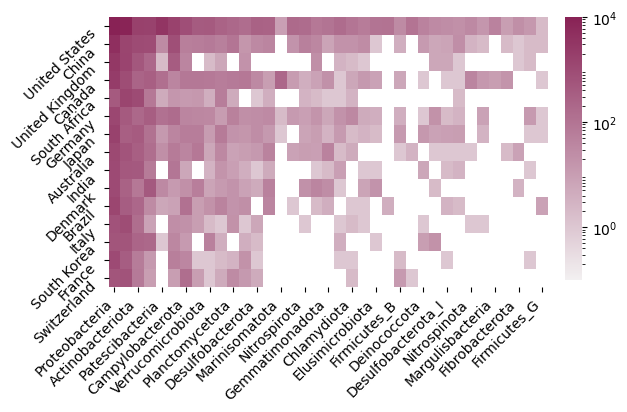

In [298]:
df_m = smalltmp.groupby(["isolation_country", "phylum"]).size().unstack(level=0)

df_m.index = pd.CategoricalIndex(df_m.index, categories= topphyla)
df_m.sort_index(level=0, inplace=True)
df_m = df_m.reindex(columns=topcountries)


lognorm = LogNorm(vmin=0.1, vmax=1E4)
fig, ax = plt.subplots(1,1,figsize=(fig_width,1*fig_height))
cbar_ax = fig.add_axes([0.93, 0.13, .03, 0.75])
g = sns.heatmap(df_m.T,norm=lognorm,
            cmap = sns.light_palette(colourDict.get("wine"), as_cmap=True),
           ax=ax, cbar_ax = cbar_ax, vmin=0.1,cbar_kws={"ticks":[1E0,1E2,1E4]})

ax.set(xlabel='',ylabel='')
cbar_ax.set_ylim(.1,1E4)

plt.yticks(rotation=0) 
g.set_yticklabels(g.get_yticklabels(), rotation = 45,va='top')
g.set_xticklabels(g.get_xticklabels(), rotation = 45,ha='right')


plt.show()
# fig.savefig('./figures/countries.png',dpi=600,bbox_inches = "tight")


## Generate metadata to import to iTOL for Figure 5

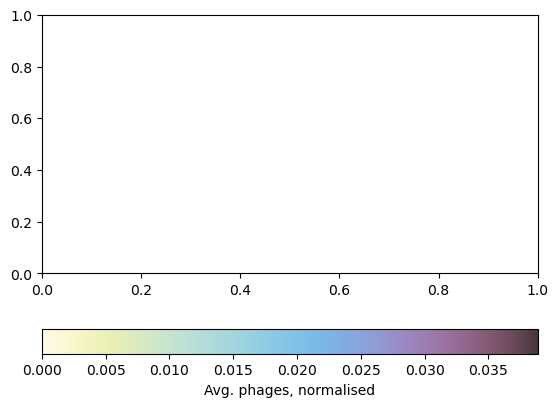

In [299]:
# Colour list
iridescent = ['#FEFBE9', '#FCF7D5', '#F5F3C1', '#EAF0B5', '#DDECBF',
        '#D0E7CA', '#C2E3D2', '#B5DDD8', '#A8D8DC', '#9BD2E1',
        '#8DCBE4', '#81C4E7', '#7BBCE7', '#7EB2E4', '#88A5DD',
        '#9398D2', '#9B8AC4', '#9D7DB2', '#9A709E', '#906388',
        '#805770', '#684957', '#46353A']

# Generate colourmap for 19557 genomes
iridCM = colors.LinearSegmentedColormap.from_list('mycols',iridescent, N=19557)
norm = colors.Normalize(vmin=0, vmax=28360)
iridArr = iridCM(np.linspace(0, 1, 19557))


balancedTaxDf = taxameta[taxameta['assembly_accession'].isin(newickList)]
phsum = balancedTaxDf.groupby('phylum').mean().reset_index()
cmap1 = iridCM
norm = Normalize(vmin=phsum['Kept_normed'].min(), vmax=phsum['Kept_normed'].max())
cmap1(phsum['Kept'])


m = cm.ScalarMappable(norm=norm, cmap=cmap1)
collist = [mpl.colors.to_hex(a) for a in m.to_rgba(phsum['Kept_normed'])]

fig, ax = plt.subplots(1,1)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap1),ax=ax,orientation='horizontal',
             label="Avg. phages, normalised")
plt.show()

# fig.savefig('./figures/colorbar.png',dpi=200)

## Supplementary Figures

#### Figure S1

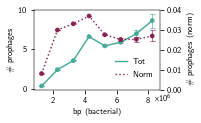

In [158]:
minval = 0
bins = list(np.arange(minval,1.2E7,1.4E6))  # 1.2
# bins += [2E8]
sizePhage = phagemeta.copy()
sizePhage = sizePhage[sizePhage['normalise_by_prok_length'] > 5E4]
# sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]

sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))
with plt.rc_context({'lines.linewidth': 0.8}):
        s1 = sns.pointplot(x='bin_centres', y='Kept', data=sizePhage,nboot=5000, ax = ax, 
                  color=colourDict.get('teal'), alpha=0.6, s=8, 
                 capsize=.3, errwidth=0.6) 

ax0 = ax.twinx()
with plt.rc_context({'lines.linewidth': 0.8}):
    s2 = sns.pointplot(x='bin_centres', y='Kept_normed', data=sizePhage, ax=ax0, n_boot=5000,
                  color=colourDict.get('wine'), alpha=0.6, s=8, linestyles=':',
                 capsize=.3, errwidth=0.6)

ax0.xaxis.offsetText.set_visible(False)
labels = ax0.get_xticklabels()
ax.set(ylabel='\# prophages',xlabel='bacteria (bp)',xticks =[0.75,2.75,4.75,6.75],xticklabels=[2,4,6,8],
      yticks=[0,5,10])
ax.text(0.96,  -0.14,'x$10^6$', transform=ax0.transAxes)
ax0.set(ylabel='\# prophages (norm)',ylim=[0,0.04])

L = ax0.legend(s1.lines[:1]+s2.lines[:1], ['A','G'],handlelength=1.5,loc='lower right',bbox_to_anchor=(1.0, 0.05),frameon=False)
L.get_texts()[0].set_text('Tot')
L.get_texts()[1].set_text('Norm')

plt.tight_layout()
plt.show()


# fig.savefig('./figures/SI/Fig_S1_fulldensity.png',dpi=300)

#### Figure S2. Plot Figs 3a and 3b assuming sample date is the isolation date for all genomes.

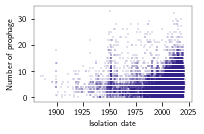

In [164]:
taxameta['isolation_date_proxy'] = taxameta.apply(lambda x: updateDate(x,magDateDict),axis=1)

fig,ax=plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))

sns.scatterplot(x='isolation_date_proxy', y='Kept', ax = ax, 
                data=taxameta[taxameta['isolation_date'] > 1850], 
                marker='+', color=colourDict.get('indigo'), alpha=0.6, s=8)
ax.set(ylabel = 'Number of prophage',xlabel='Isolation date')
plt.show()
fig.savefig('./figures/SI/FigS2a.png',dpi=300)

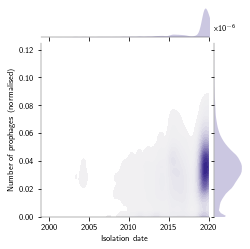

In [179]:
tmpKDE2 = taxameta[taxameta['isolation_date_proxy'] > 2000]

gr = sns.JointGrid(x='isolation_date_proxy', y='Kept_normed', data=tmpKDE2,xlim=(1999, 2020), ylim=(0, 0.125), height=fig_height) # counts normed by genome length
gr.plot_joint(sns.kdeplot, fill=True, cmap="light:"+colourDict.get('indigo'), n_levels=25,cbar=False)
gr.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=1.4,color=colourDict.get('indigo')) # "#03012d"

gr.ax_joint.set_xlabel('Isolation date')
gr.ax_joint.set_ylabel('Number of prophages (normalised)')

gr.ax_joint.yaxis.offsetText.set_visible(False)
gr.ax_joint.text(x = 1.03, y = 1.07, s = 'x$10^{-6}$', transform=gr.ax_joint.transAxes)#,xy=(0.01,1), xycoords='figure fraction')
plt.setp(gr.ax_marg_y.get_yticklabels(), visible=False)

plt.show()

# gr.savefig('./figures/SI/FigS2b.png',dpi=300)

#### Figure S3. Do the lysogens or non-lysogens become more frequent over time? Or is it consistent?

Note that the regression is fitted on data up until 2012, and due to the log scale, 1 has been added to both the x and y data to prevent undefined values. 

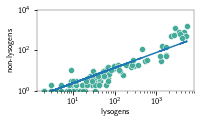

In [57]:
tp = phagemeta[phagemeta['isolation_date'].notnull()]

bins2 = np.arange(1810,2020,1)
yearTaxa2 = phagemeta.copy()
yearTaxa2 = yearTaxa2[~yearTaxa2['isolation_date'].isnull()]
yearTaxa2 = yearTaxa2[yearTaxa2['isolation_date'] <= 2019]
yearTaxa2['bin'] = pd.cut(phagemeta['isolation_date'], bins2)
yearTaxa2["bin_centres"] = yearTaxa2["bin"].apply(lambda x: x.mid).astype(np.float64)
# yearTaxa_dropNaN = yearTaxa[~yearTaxa['isolation_date'].isna()]
binsets3 = list(yearTaxa2['bin_centres'].unique())
yearList3 = []
yearList4 = []

for binVal in np.sort(binsets3):
    num = len(yearTaxa2[yearTaxa2['bin_centres'] == binVal])
    subDf = yearTaxa2[yearTaxa2['bin_centres'] == binVal]
    numzeros = len(subDf[subDf['Kept'] == 0])
    numzeros2 = len(subDf[subDf['Kept'] != 0])
    yearList3 += [numzeros]
    yearList4 += [numzeros2]


xi= np.array(yearList4)+1
yi = np.array(yearList3)+1

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))
ax=sns.scatterplot(x=xi,y=yi, color=colourDict.get('teal'),lw=0)
ax.set(yscale='log',ylim=[1,1E4],xscale='log', ylabel='non-lysogens',xlabel='lysogens')  


idx = len(binsets3) - 7
m, b = np.polyfit(np.log(xi[0:idx]), np.log(yi[0:idx]), 1)

y_fit = np.exp(m*np.array(np.log(xi) + b))
plt.plot(np.array(xi), y_fit)

plt.tight_layout()
plt.show()

# fig.savefig('figures/SI/S2-lysogens_non-lysogens.png',dpi=200)

### Figure S4: qualitative consistency for Figure 3d at different phylogenetic levels (normalised prophage counts against first isolated) 

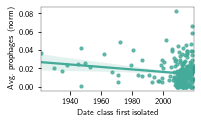

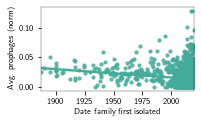

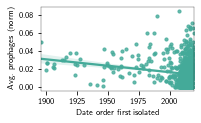

In [180]:
levels = ['class','family','order']

for lev in levels:
    normtype = 'Kept_normed'
    earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[lev,'isolation_date']
                                                                     ].groupby(lev).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
    earliestDict = dict(zip(earliestIsoltionDf[lev],earliestIsoltionDf['isolation_datemin']))

    firstIsolated = taxameta.groupby(lev).mean().reset_index()
    firstIsolated = firstIsolated[firstIsolated['isolation_datemin'] > 1850]

    fig,ax=plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))

    sns.regplot(x=firstIsolated['isolation_datemin'],y=firstIsolated[normtype],
               scatter_kws={'s':10},color=colourDict.get('teal'), ax=ax)

    ax.set(xlabel='Date '+lev+' first isolated',ylabel='Avg. prophages (norm)')
    plt.tight_layout()
    plt.show()
    fig.savefig('./figures/SI/S4_'+lev+'.png',dpi=200)

# Other supp figures from May

Rob's questions figures below

#### Change binsizes for Fig 2a to see how that impacts results

Either choose have the line below "Include all genomes" or "Exclude non-lysogens" to see the behaviour

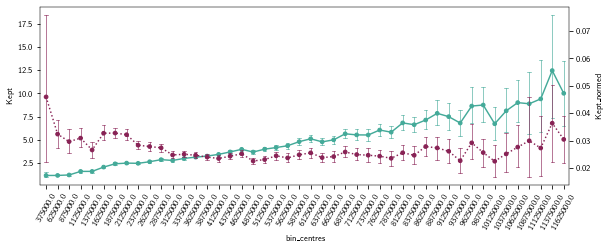

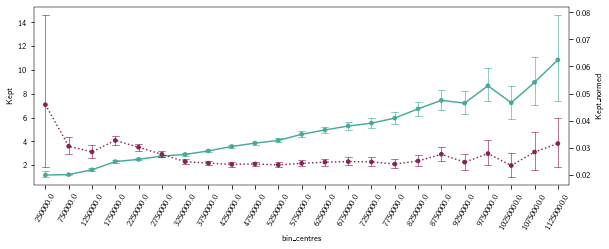

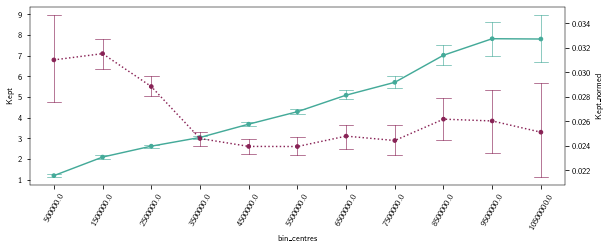

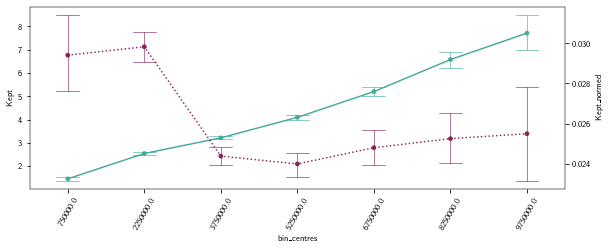

In [83]:
minval = 0

for binsize in [0.25E6, 0.5E6, 1E6, 1.5E6]:
    bins = list(np.arange(minval,1.2E7,binsize))  # 1.2
    sizePhage = taxameta.copy()
    
    # Include all genomes
#     sizePhage = sizePhage[(sizePhage['normalise_by_prok_length'] > 5E4)]
    
    # Exclude non-lysogens
    sizePhage = sizePhage[(sizePhage['normalise_by_prok_length'] > 5E4) & (sizePhage['Kept'] >= 1)]
    
    
    sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]
    sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
    sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)

    fig, ax0 = plt.subplots(1,1, figsize=(1.5*fig_width,fig_height))

    balancedSizePhage = sizePhage.copy()

    with plt.rc_context({'lines.linewidth': 0.8}):
            s1 = sns.pointplot(x='bin_centres', y='Kept', data=balancedSizePhage,nboot=1000, ax = ax0, 
                      color=colourDict.get('teal'), alpha=0.6, s=8, 
                     capsize=.3, errwidth=0.6) 

    ax3 = ax0.twinx()
    with plt.rc_context({'lines.linewidth': 0.8}):
        s2 = sns.pointplot(x='bin_centres', y='Kept_normed', data=balancedSizePhage, ax=ax3, n_boot=1000,
                      color=colourDict.get('wine'), alpha=0.6, s=8, linestyles=':',
                     capsize=.3, errwidth=0.6)

    labels = ax0.get_xticklabels()
    # ax0.set(ylabel='\# prophages',xlabel='bacteria (bp)',xticks =[0.75,2.75,4.75,6.75],xticklabels=[2,4,6,8])
#     ax0.text(0.96,  -0.04,'x$10^6$', transform=ax0.transAxes)
    ax0.set_xticklabels(ax0.get_xticklabels(),rotation = 60)
    plt.tight_layout()
    plt.show()
    
#     fig.savefig('./figures/F2a_lysogens_only%.2E.png' % binsize, dpi=200)
#     fig.savefig('./figures/F2a_%.2E.png' % binsize, dpi=200)

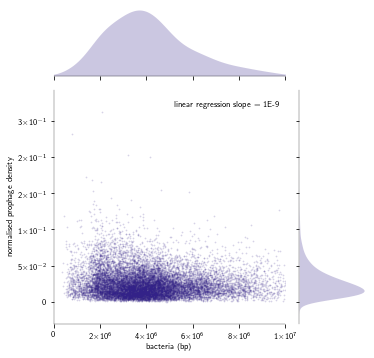

In [43]:
# Create plot handle and plot data
gt = sns.JointGrid(x='normalise_by_prok_length', y='Kept_normed', 
                   data=balancedSizePhage[(balancedSizePhage['Kept'] >= 1) & 
                                  (balancedSizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (balancedSizePhage['bp prophage'] < 5E6)],
                  xlim=(0,1e7), marginal_ticks=False,ratio=3, height=5) # counts normed by genome length

gt.plot_joint(
    sns.scatterplot, s=3, alpha=0.2, linewidth=0, color=colourDict.get('indigo'))#,rasterized=True)
gt.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=2,color=colourDict.get('indigo'))

# Format axes
gt.ax_joint.set_xlabel('bacteria (bp)')
gt.ax_joint.set_ylabel('normalised prophage density')
gt.ax_joint.set_xticks([0,2E6,4E6,6E6,8E6,1E7])
gt.ax_joint.yaxis.set_major_formatter(MathTextSciFormatter("%1.0e")), gt.ax_joint.xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
plt.setp(gt.ax_marg_y.get_xaxis().get_offset_text(), visible=False)
plt.setp(gt.ax_marg_x.get_yaxis().get_offset_text(), visible=False)

plt.annotate('linear regression slope = 1E-9',(0.465,0.7),xycoords='figure fraction',weight='bold')
# Test plot
plt.show()

# gt.savefig('./figures/binsizesFig2.png',dpi=300)

In [63]:
print('regression for scatterplot above')
scp.stats.linregress(balancedSizePhage['normalise_by_prok_length'],balancedSizePhage['Kept_normed'])

regression for scatterplot above


LinregressResult(slope=1.735624385638086e-09, intercept=0.014073481243098596, rvalue=0.17786684566399294, pvalue=4.786730506633077e-131, stderr=7.068237427315633e-11, intercept_stderr=0.00029809802310739637)